# Ielādē pakotnes

In [1]:
# Ielādē aprēķināšanas pakotnes
print('Ielādē pakotnes... ', flush=True, end='')
import math
import numpy as np
from functools import reduce
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
from scipy import linalg as la

# Ielādē lasīšanas pakotnes
import pandas as pd
import geopandas as gpd
import json

# Ielādē zīmēšanas pakotnes
import matplotlib.pyplot as plt
import seaborn as sns
print('ielādētas', flush=True)

Ielādē pakotnes... ielādētas


# Definē funckijas

In [2]:
print('Definē funkcijas... ', flush=True, end='')

# Inverse distance weighting funkcija
# https://stackoverflow.com/a/3114117/2272367
def simple_idw(x, y, z, xi, yi, power=2):
    dist = distance_matrix(x,(y-24.10938688375723)*1.5,xi,(yi-24.10938688375723)*1.5) # modifikācija LV

    # In IDW, weights are 1 / distance
    weights = 1.0 / dist**power

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    # (Yay for ufuncs!)
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

# Aizkrāso visu ārpus definēta poligona
# https://stackoverflow.com/a/4817951/2272367
def mask_outside_polygon(poly_verts, ax=None):
    """
    Plots a mask on the specified axis ("ax", defaults to plt.gca()) such that
    all areas outside of the polygon specified by "poly_verts" are masked.  

    "poly_verts" must be a list of tuples of the verticies in the polygon in
    counter-clockwise order.

    Returns the matplotlib.patches.PathPatch instance plotted on the figure.
    """
    import matplotlib.patches as mpatches
    import matplotlib.path as mpath

    if ax is None:
        ax = plt.gca()

    # Get current plot limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Verticies of the plot boundaries in clockwise order
    bound_verts = [(xlim[0], ylim[0]), (xlim[0], ylim[1]), 
                   (xlim[1], ylim[1]), (xlim[1], ylim[0]), 
                   (xlim[0], ylim[0])]

    # A series of codes (1 and 2) to tell matplotlib whether to draw a line or 
    # move the "pen" (So that there's no connecting line)
    bound_codes = [mpath.Path.MOVETO] + (len(bound_verts) - 1) * [mpath.Path.LINETO]
    poly_codes = [mpath.Path.MOVETO] + (len(poly_verts) - 1) * [mpath.Path.LINETO]

    # Plot the masking patch
    path = mpath.Path(bound_verts + poly_verts, bound_codes + poly_codes)
    patch = mpatches.PathPatch(path, facecolor='white', edgecolor='none', zorder=4)
    # patch = mpatches.PathPatch(path, facecolor=(1,1,1,.5), edgecolor='none')
    patch = ax.add_patch(patch)

    # Reset the plot limits to their original extents
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    return patch

# Convert no LV koordinātem uz normālām
# https://gist.github.com/laacz/2597627
def LKSToLatLon(x, y):
    UTMScaleFactor = 0.9996
    sm_a = 6378137.0
    sm_b = 6356752.314
    x -=  500000.0
    y -= -6000000.0
    x /=  UTMScaleFactor
    y /=  UTMScaleFactor
    lambda0 = math.radians(24)
    n = (sm_a - sm_b) / (sm_a + sm_b)
    alpha_ = ((sm_a + sm_b) / 2.0) * (1 + (math.pow(n, 2.0) / 4) + (math.pow(n, 4.0) / 64))
    y_ = y / alpha_
    beta_ = (3.0 * n / 2.0) + (-27.0 * math.pow(n, 3.0) / 32.0)+ (269.0 * math.pow(n, 5.0) / 512.0)
    gamma_ = (21.0 * math.pow(n, 2.0) / 16.0) + (-55.0 * math.pow(n, 4.0) / 32.0)
    delta_ = (151.0 * math.pow(n, 3.0) / 96.0) + (-417.0 * math.pow(n, 5.0) / 128.0)
    epsilon_ = (1097.0 * math.pow(n, 4.0) / 512.0)
    phif = y_ + (beta_ * math.sin(2.0 * y_)) + (gamma_ * math.sin(4.0 * y_)) + (delta_ * math.sin(6.0 * y_)) + (epsilon_ * math.sin(8.0 * y_))
    ep2 = (math.pow(sm_a, 2.0) - math.pow(sm_b, 2.0)) / math.pow(sm_b, 2.0)
    cf = math.cos(phif)
    nuf2 = ep2 * math.pow(cf, 2.0)
    Nf = math.pow(sm_a, 2.0) / (sm_b * math.sqrt(1 + nuf2))
    Nfpow = Nf
    tf = math.tan(phif)
    tf2 = tf * tf
    tf4 = tf2 * tf2
    x1frac = 1.0 / (Nfpow * cf)
    Nfpow *=  Nf   
    x2frac = tf / (2.0 * Nfpow)
    Nfpow *=  Nf   
    x3frac = 1.0 / (6.0 * Nfpow * cf)
    Nfpow *=  Nf   
    x4frac = tf / (24.0 * Nfpow)
    Nfpow *=  Nf   
    x5frac = 1.0 / (120.0 * Nfpow * cf)
    Nfpow *=  Nf   
    x6frac = tf / (720.0 * Nfpow)
    Nfpow *=  Nf   
    x7frac = 1.0 / (5040.0 * Nfpow * cf)
    Nfpow *=  Nf   
    x8frac = tf / (40320.0 * Nfpow)
    x2poly = -1.0 - nuf2
    x3poly = -1.0 - 2 * tf2 - nuf2
    x4poly = 5.0 + 3.0 * tf2 + 6.0 * nuf2 - 6.0 * tf2 * nuf2 - 3.0 * (nuf2 * nuf2) - 9.0 * tf2 * (nuf2 * nuf2)
    x5poly = 5.0 + 28.0 * tf2 + 24.0 * tf4 + 6.0 * nuf2 + 8.0 * tf2 * nuf2
    x6poly = -61.0 - 90.0 * tf2 - 45.0 * tf4 - 107.0 * nuf2 + 162.0 * tf2 * nuf2
    x7poly = -61.0 - 662.0 * tf2 - 1320.0 * tf4 - 720.0 * (tf4 * tf2)
    x8poly = 1385.0 + 3633.0 * tf2 + 4095.0 * tf4 + 1575 * (tf4 * tf2)
    lat = phif + x2frac * x2poly * (x * x) + x4frac * x4poly * math.pow(x, 4.0) + x6frac * x6poly * math.pow(x, 6.0) + x8frac * x8poly * math.pow(x, 8.0)
    lon = lambda0 + x1frac * x + x3frac * x3poly * math.pow(x, 3.0) + x5frac * x5poly * math.pow(x, 5.0) + x7frac * x7poly * math.pow(x, 7.0)
    return [math.degrees(lat), math.degrees(lon)]

print('definētas', flush=True)

Definē funkcijas... definētas


# Ielādē failus un definē objektus

In [3]:
# Nosaki mapes
root = ''
export_dir = ''

# Lasi galveno CVK failu
# https://data.gov.lv/dati/lv/dataset/14-saeimas-velesanas-sv2022
print('Lasa vēlēšanu rezultātus... ', end='', flush=True)
with open(root+'departmentresults.json', 'r') as f:
    data = json.load(f)
print('ielasīti', flush=True)

# Lasi galveno VAR failu
# https://data.gov.lv/dati/lv/dataset/valsts-adresu-registra-informacijas-sistemas-atvertie-dati/resource/f539e8df-d4e4-4fc1-9f94-d25b662a4c38
print('Lasa valsts adrešu sarakstu... ', end='', flush=True)
shapefile = gpd.read_file(root+'Ekas.shp')
print('ielasīts', flush=True)

# Latvijas zemes robeža
print('Ielādē robežas... ', end='', flush=True)
# https://www.openstreetmap.org/relation/72594
with open(root+'export.kml','r', encoding='utf-8-sig') as f:
    land_raw = f.readlines()
land = [[float(p) for p in k.split(',')] for k in land_raw[0].split(' ')]

# Latvijas jūras robeža
# https://earthworks.stanford.edu/catalog/stanford-kz847zb8856
with open(root+'stanford-kz847zb8856-geojson.json', 'r') as f:
    sea_raw = json.load(f)
sea = sea_raw['features'][0]['geometry']['coordinates'][0]

# Latvijas robeža, apvienota
boundary = np.vstack((np.array(land[:-752]),np.array(sea)))
boundary_forplotting = np.transpose(np.array(boundary))

# Rīgas robeža
# https://www.kaggle.com/datasets/dmitryyemelyanov/riga-city-boundaries-geojson
with open(root+'riga_boundaries_polygon.json','r') as f:
    riga_raw = json.load(f)
riga = np.array(riga_raw['geometries'][0]['coordinates'][0][0])
riga_forplotting = np.transpose(np.array(riga))

# Novadu robežas
# https://data.gov.lv/dati/lv/dataset/atr/resource/3ded58bd-c0dc-419a-97ff-59ba45a7b1b0
with open(root+'administrativas_teritorijas_2021.geojson','r') as f:
    novadi_raw = json.load(f)
novadi_coordinates_raw = [novads['geometry']['coordinates'][0][0] for novads in novadi_raw['features']]
novadi_coordinates = []
for novads in novadi_coordinates_raw:
    current_novads = []
    for coordinate in novads:
        current_novads.append(LKSToLatLon(coordinate[0],coordinate[1])[::-1])
    novadi_coordinates.append(current_novads)

print('ielādētas', flush=True)

Lasa vēlēšanu rezultātus... ielasīti
Lasa valsts adrešu sarakstu... ielasīts
Ielādē robežas... ielādētas


# Definē vispārējas kopas

In [4]:
# Lasi kopējos vēlēšanu rezultātus
print('Lasa kopējos vēlēsanu rezultātus', flush=True)
results_full = {'total_votes':data[0]['ValidMarkCount']['Count']}
for partija_dict in data[0]['CandidateLists']:
    results_full[partija_dict['Id']] = partija_dict['ValidMarkCount']['Count']

# Partijas
print('Definē partiju nosaukumus', flush=True)
partijas = ['jauna-vienotiba', 'latvijas-krievu-savieniba', 'zalo-un-zemnieku-savieniba',
 'tautas-kalpi-latvijai', 'suverena-vara', 'kristigi-progresiva-partija',
 'saskana-socialdemokratiska-partija', 'politiska-partija-stabilitatei',
 'politiska-partija-tautas-varas-speks', 'partija-vienoti-latvijai', 
 'nacionala-apvieniba-visu-latvijai-tevzemei-un-brivibai-lnnk',
 'latvija-pirmaja-vieta', 'konservativie', 'politiska-partija-katram-un-katrai',
 'progresivie', 'attistibai-par', 'apvieniba-latvijai',
 'apvienotais-saraksts-latvijas-zala-partija-latvijas-regionu-apvieniba-liepajas-partija',
 'politiska-partija-republika'
           ]
partijas_shortnames = {
 'jauna-vienotiba':'jauna-vienotiba',
 'latvijas-krievu-savieniba':'latvijas-krievu-savieniba',
 'zalo-un-zemnieku-savieniba':'zalo-un-zemnieku-savieniba',
 'tautas-kalpi-latvijai':'tautas-kalpi-latvijai',
 'suverena-vara':'suverena-vara',
 'kristigi-progresiva-partija':'kristigi-progresiva-partija',
 'saskana-socialdemokratiska-partija':'saskana',
 'politiska-partija-stabilitatei':'stabilitatei',
 'politiska-partija-tautas-varas-speks':'tautas-varas-speks',
 'partija-vienoti-latvijai':'vienoti-latvijai', 
 'nacionala-apvieniba-visu-latvijai-tevzemei-un-brivibai-lnnk':'nacionala-apvieniba',
 'latvija-pirmaja-vieta':'latvija-pirmaja-vieta',
 'konservativie':'konservativie',
 'politiska-partija-katram-un-katrai':'katram-un-katrai',
 'progresivie':'progresivie',
 'attistibai-par':'attistibai-par',
 'apvieniba-latvijai':'apvieniba-latvijai',
 'apvienotais-saraksts-latvijas-zala-partija-latvijas-regionu-apvieniba-liepajas-partija':'apvienotais-saraksts',
 'politiska-partija-republika':'republika'
}
partijas_nicenames = {
 'jauna-vienotiba':'Jaunā Vienotība',
 'latvijas-krievu-savieniba':'Latvijas krievu savienība',
 'zalo-un-zemnieku-savieniba':'Zaļo un zemnieku savienība',
 'tautas-kalpi-latvijai':'Tautas kalpi Latvijai',
 'suverena-vara':'Suverēnā vara',
 'kristigi-progresiva-partija':'Kristīgi progresīvā partija',
 'saskana-socialdemokratiska-partija':'Saskaņa',
 'politiska-partija-stabilitatei':'Stabilitātei!',
 'politiska-partija-tautas-varas-speks':'Tautas varas spēks',
 'partija-vienoti-latvijai':'Vienoti Latvijai', 
 'nacionala-apvieniba-visu-latvijai-tevzemei-un-brivibai-lnnk':'Nacionālā apvienība',
 'latvija-pirmaja-vieta':'Latvija pirmā vietā',
 'konservativie':'Konservatīvie',
 'politiska-partija-katram-un-katrai':'Katram un katrai',
 'progresivie':'Progresīvie',
 'attistibai-par':'Attīstībai / Par!',
 'apvieniba-latvijai':'Apvienība Latvijai',
 'apvienotais-saraksts-latvijas-zala-partija-latvijas-regionu-apvieniba-liepajas-partija':'Apvienotais saraksts',
 'politiska-partija-republika':'Republika'
}

# Partiju kārtība vēlešanu rezultātos
all_order = [1,3,18,11,8,12,15,16,7,14,2,5,13,19,9,4,17,6,10]
partijas = [partijas[spot-1] for spot in all_order]

print('Pabeigts', flush=True)

Lasa kopējos vēlēsanu rezultātus
Definē partiju nosaukumus
Pabeigts


# Atrodi unikālās iecrikņu adreses
Dažās adresēs ir divi iecirkņi, galvenokārt Rīgā. Cik saprotu, papildus iecirkņi tiek veidoti sagaidot / esot jau pārpildītā iecirknī. Pēc būtības nevajadzētu atšķirt šādus iecrikņus, jo ģeogrāfiski tie apzīmē vienu un to pašu vietu.

In [5]:
# Saraksti ar vietējiem un ārzemju iecirkņiem
print('Veido sarakstu ar vietējiem un ārzemju iecirkņiem', flush=True)
cvkindex_arzemes = []
cvkindex_local = []
adreses_local = {}
for i,entry in enumerate(data):
    current_department = entry['Department']
    if 'Address' in current_department:
        if current_department['ParentId'] == 'arzemes':
            cvkindex_arzemes.append(i)
        else:
            cvkindex_local.append(i)
            try:
                adreses_local[current_department['Address']].append(i)
            except:
                adreses_local[current_department['Address']] = [i]

# Unikālas adreses
adreses_unique = np.unique(np.array([entry['Department']['Address'] for i,entry in enumerate(data) if i in cvkindex_local]))

print('Atrasti '+str(len(cvkindex_local))+' iecirkņi Latvijā', flush=True)
print('Atrastas '+str(len(adreses_unique))+' unikālas iecrikņu adreses Latvijā', flush=True)
print('Atrasti '+str(len(cvkindex_arzemes))+' iecirkņi ārzemēs', flush=True)

Veido sarakstu ar vietējiem un ārzemju iecirkņiem
Atrasti 951 iecirkņi Latvijā
Atrastas 903 unikālas iecrikņu adreses Latvijā
Atrasti 104 iecirkņi ārzemēs


# Lasi iecirkņu rezultātus un ģeogrāfiskās koordinātes
Ja vairāki iecirkņi vienā adresē, tie tiks apvienoti

In [6]:
# Definē objektu
results_dict = {'adrese':[], 'nosaukums':[], 'indices':[], 'ids':[], 'total_votes':[]}
for partija in partijas:
    results_dict[partija] = []
    
# Collect all results
print('Global: Lasa vispārējos rezultātus', flush=True)
results_full = {'total_votes':data[0]['ValidMarkCount']['Count']}
for partija_dict in data[0]['CandidateLists']:
    results_full[partija_dict['Id']] = partija_dict['ValidMarkCount']['Count']

print('Local: Lasa katra iecirkņa rezultātus', flush=True)
for adrese in adreses_local:
    
    # Basic data
    i = adreses_local[adrese][0]
    current_department = data[i]['Department']
    current_results = data[i]['CandidateLists']
    results_dict['adrese'].append(current_department['Address'])
    results_dict['nosaukums'].append(current_department['Name'])

    # One iecirknis
    if len(adreses_local[adrese]) == 1:
        results_dict['indices'].append(str(i))
        results_dict['ids'].append(str(current_department['Id']))
        
        # Copy properties of data
        results_dict['total_votes'].append(data[i]['ValidMarkCount']['Count'])
        for k in range(len(current_results)):
            current_partija = current_results[k]['Id']
            results_dict[current_partija].append(current_results[k]['ValidMarkCount']['Count'])
            
    # Divi vai trīs iecirkņi
    elif len(adreses_local[adrese]) in [2,3]:
        current_departments = [data[j]['Department'] for j in adreses_local[adrese]]
        results_dict['indices'].append(reduce(lambda x,y:x+y, [str(a) for a in adreses_local[adrese]]))
        results_dict['ids'].append(reduce(lambda x,y:x+y, [str(d['Id']) for d in current_departments]))

        # Copy properties of data
        results_dict['total_votes'].append(reduce(lambda x,y:x+y, [data[j]['ValidMarkCount']['Count'] for j in adreses_local[adrese]]))
        for k in range(len(current_results)):
            assert len(np.unique([data[j]['CandidateLists'][k]['Name'] for j in adreses_local[adrese]])) == 1,'Partijas nav visas vienadas'
            current_partija = current_results[k]['Id']
            results_dict[current_partija].append(reduce(lambda x,y:x+y, [data[j]['CandidateLists'][k]['ValidMarkCount']['Count'] for j in adreses_local[adrese]]))

    else:
        print('Warning: Adrese with length neither 1 nor 2 nor 3 at index '+str(i)+' with name '+adrese,flush=True)
        print(adreses_local[adrese])
           
print('Veido pandas dataframe ar rezultātiem', flush=True)
df_local_results = pd.DataFrame.from_dict(results_dict)

print('Āzremes: Lasa katra iecirkņa rezultātus', flush=True)
# Arzemes results    
results_dict = {'Index':[], 'Code':[], 'Id':[], 'Number':[], 'Name':[], 'Address':[], 'total_votes':[]}
for partija in partijas:
    results_dict[partija] = []
    
for i in cvkindex_arzemes:
    
    # Copy properties of data
    current_department = data[i]['Department']
    results_dict['Index'].append(i)
    results_dict['Code'].append(current_department['Code'])
    results_dict['Id'].append(current_department['Id'])
    results_dict['Number'].append(current_department['Number'])
    results_dict['Name'].append(current_department['Name'])
    results_dict['Address'].append(current_department['Address'])
    
    # Copy results
    current_results = data[i]['CandidateLists']
    results_dict['total_votes'].append(data[i]['ValidMarkCount']['Count'])
    for j in range(len(current_results)):
        current_partija = current_results[j]['Id']
        results_dict[current_partija].append(current_results[j]['ValidMarkCount']['Count'])

print('Veido pandas dataframe ar rezultātiem', flush=True)
df_arzemes_results = pd.DataFrame.from_dict(results_dict)

# Vairāk par to, kā šis aprēķināts dokumenta apakšā
print('Lasa aprēķinātās ģeogrāfiskās koordinātes', flush=True)
df_local_coords = pd.read_pickle('cvk-var-local.pkl')

print('Pārkārto', flush=True)
local_index = [np.where(df_local_results['adrese'] == adrese)[0][0] for adrese in df_local_coords['adrese']]
df_local_results = df_local_results.reindex(local_index).reset_index(drop=True)

print('Pabeigts', flush=True)

Global: Lasa vispārējos rezultātus
Local: Lasa katra iecirkņa rezultātus
Veido pandas dataframe ar rezultātiem
Āzremes: Lasa katra iecirkņa rezultātus
Veido pandas dataframe ar rezultātiem
Lasa aprēķinātās ģeogrāfiskās koordinātes
Pārkārto
Pabeigts


# Grafiks 1: Kur atrodas iecirkņi

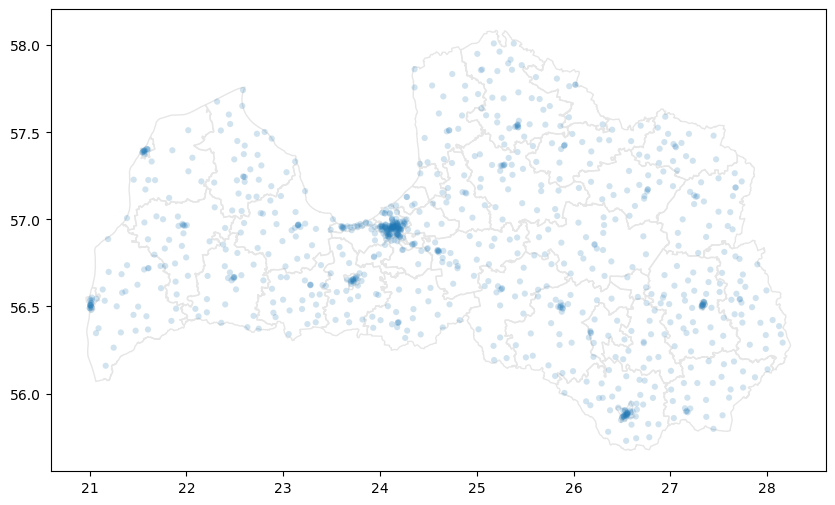

In [7]:
# Initiate
fig = plt.figure(figsize=(10,6))
ax = plt.gca()

# Coordinates
ax.scatter(df_local_coords['lng'], df_local_coords['lat'], s=20, edgecolors='none', alpha=.2, zorder=2)

# Novadi outlines
for novads in novadi_coordinates:
    novads_forplotting = np.transpose(np.array(novads))
    ax.plot(novads_forplotting[0], novads_forplotting[1], c=(.9,.9,.9), lw=1, zorder=-2)

# Show
plt.show()

# Izmēri "attālumus" iecirkņu rezultātos
Attālums starp kādu iecirkni, kur par (piemēram) Jauno Vienotību balsoja $p_1$ procenti, un iecirkni, kur par Jauno Vienotību balsoja $p'_1$ procenti ir $\sqrt{(p_1-p'_1)^2+(p_2-p'_2)^2 + \cdots + (p_{19}-p'_{19})^2}$. Pārējie $p_i$ un $p'_i$ ir procenti par pārējām partijām. Kopā bija 19 partijas.

Gaiša krāsa = līdzīgi rezultāti

Tumša krāsa = atšķirīgi rezultāti

Constructing local matrix... done
Constructing arzemes matrix... done
Constructing mixed matrix... done
Padding with distance to full results... done


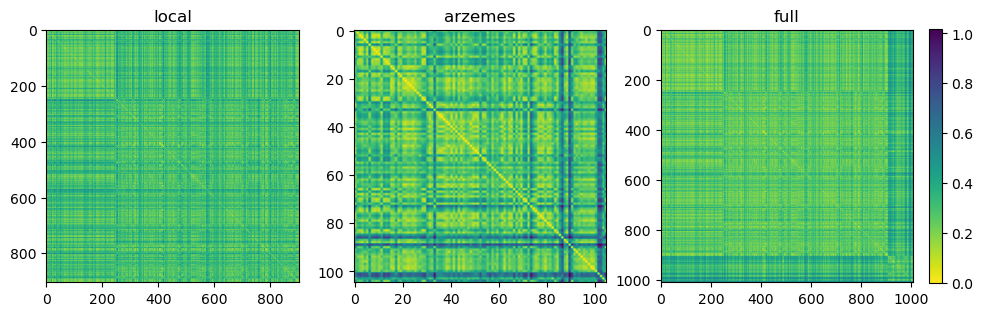

In [7]:
# Local
print('Constructing local matrix... ', end='', flush=True)
M_local_raw = np.zeros((df_local_results.shape[0],df_local_results.shape[0]))
vectors_local = []
for i in range(df_local_results.shape[0]):
    row = df_local_results.iloc[i]
    vector = np.array([row[partija]/row['total_votes'] for partija in partijas])
    vectors_local.append(vector)
for i in range(df_local_results.shape[0]):
    for j in range(i+1,df_local_results.shape[0]):
        distance = np.linalg.norm(vectors_local[i]-vectors_local[j])
        M_local_raw[i][j] = distance
        M_local_raw[j][i] = distance
print('done', flush=True)

# Arzemes
print('Constructing arzemes matrix... ', end='', flush=True)
M_arzemes_raw = np.zeros((df_arzemes_results.shape[0],df_arzemes_results.shape[0]))
vectors_arzemes = []
for i in range(df_arzemes_results.shape[0]):
    row = df_arzemes_results.iloc[i]
    vector = np.array([row[partija]/row['total_votes'] for partija in partijas])
    vectors_arzemes.append(vector)    
for i in range(df_arzemes_results.shape[0]):
    for j in range(i+1,df_arzemes_results.shape[0]):
        distance = np.linalg.norm(vectors_arzemes[i]-vectors_arzemes[j])
        M_arzemes_raw[i][j] = distance
        M_arzemes_raw[j][i] = distance
print('done', flush=True)

# Mixed
print('Constructing mixed matrix... ', end='', flush=True)
M_mixed_raw = np.zeros((df_local_results.shape[0],df_arzemes_results.shape[0]))
for i in range(df_local_results.shape[0]):
    for j in range(df_arzemes_results.shape[0]):
        distance = np.linalg.norm(vectors_local[i]-vectors_arzemes[j])
        M_mixed_raw[i][j] = distance
print('done', flush=True)

# Add distance to full
print('Padding with distance to full results... ', end='', flush=True)
full_vector = np.array([results_full[partija]/results_full['total_votes'] for partija in partijas])

local_tofull = []
for i in range(df_local_results.shape[0]):
    distance = np.linalg.norm(vectors_local[i]-full_vector)
    local_tofull.append(distance)
local_tofull_array = np.hstack((np.array([0]), np.array(local_tofull)))
M_local = np.hstack((np.array([local_tofull]).T,M_local_raw))
M_local = np.vstack((local_tofull_array,M_local))

arzemes_tofull = []
for i in range(df_arzemes_results.shape[0]):
    distance = np.linalg.norm(vectors_arzemes[i]-full_vector)
    arzemes_tofull.append(distance)
arzemes_tofull_array = np.hstack((np.array([0]), np.array(arzemes_tofull)))
M_arzemes = np.hstack((np.array([arzemes_tofull]).T,M_arzemes_raw))
M_arzemes = np.vstack((arzemes_tofull_array,M_arzemes))

tofull = np.hstack((np.array(local_tofull),np.array(arzemes_tofull)))
M_full = np.hstack((M_local_raw,M_mixed_raw))
M_full = np.vstack((M_full,np.hstack((np.transpose(M_mixed_raw),M_arzemes_raw))))
M_full = np.hstack((np.array([tofull]).T,M_full))
M_full = np.vstack((np.hstack((np.array([0]),tofull)),M_full))
print('done', flush=True)

# Extrema
local_min = min(M_local[0][1:])
local_max = max(M_local[0][1:])
full_min = min(M_full[0][1:])
full_max = max(M_full[0][1:])

# Plot heatmap of distance
fig,axes = plt.subplots(1,3,figsize=(12,6),width_ratios=[1,1,1.25])
axes[0].imshow(M_local,cmap='viridis_r')
axes[0].set_title('local')
axes[1].imshow(M_arzemes,cmap='viridis_r')
axes[1].set_title('arzemes')
full_axes = axes[2].imshow(M_full,cmap='viridis_r')
axes[2].set_title('full')
    
# Colorbar
plt.colorbar(full_axes,ax=axes[2],shrink=.55)

# Show
plt.show()

# Grafiks 2: Klāsteri
Tā pati krāsu shēma (gaišs = līdzīgs, tumšs = atšķirīgs).

Klāsteru aprēķināšanas metode savieno tuvākos iecirkņus, tad turpina tuvākos pievienot, līdz kamēr visi pievienoti kādam klāsterim. Šī ir "nearest-neighbor" metode.

Krāsas kreisā pusē izvēlētas pēdējos septiņus klāsterus izcelt.

<Figure size 640x480 with 0 Axes>

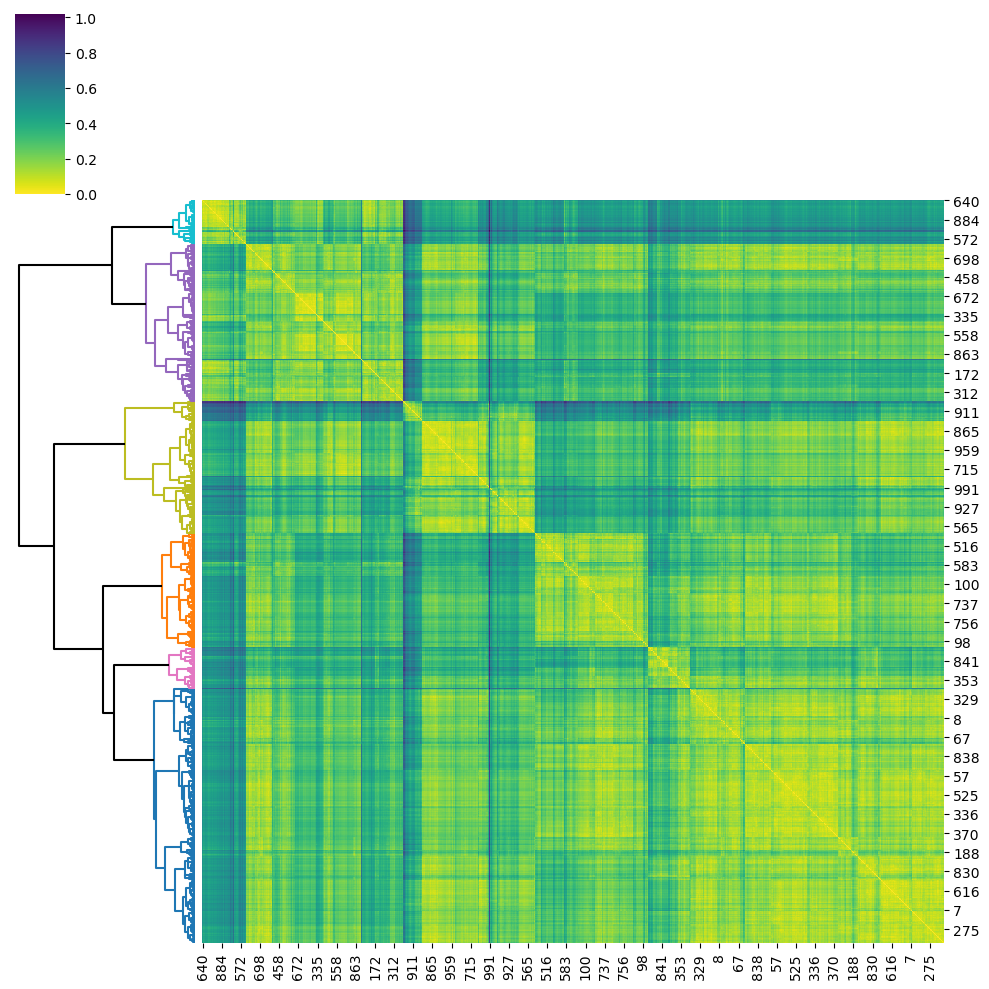

In [8]:
# Cluster by distance
fig = plt.figure()
threshold = 2.1
colors = ['C0','C6','C1','C8','C4','C9']
colors_forplotting = colors[::-1]

# Construct cluster
M_full_fordrawing = np.delete(M_full, (0), axis=0)
M_full_fordrawing = np.delete(M_full_fordrawing, (0), axis=1)
dist_array = ssd.squareform(M_full_fordrawing)
M2 = hierarchy.linkage(dist_array, method='ward')

# Draw heatmap
heat = sns.clustermap(
      M_full_fordrawing,
      row_linkage=M2,
      col_linkage=M2,
      dendrogram_ratio=.2,
      figsize=(10,10),
      tree_kws={"linewidths": 0.},
    cmap='viridis_r'
  )

# Draw dendrogram
default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
name_to_hex = {'C'+str(i):default_colors[i] for i in range(10)}
dendrogram_colors = [name_to_hex[color] for color in colors]
hierarchy.set_link_color_palette(dendrogram_colors)
den = hierarchy.dendrogram(M2,
    color_threshold=threshold,
    distance_sort='descending',
    ax=heat.ax_row_dendrogram,
    orientation='left',
    above_threshold_color='#000000'
)

# Show
plt.show()

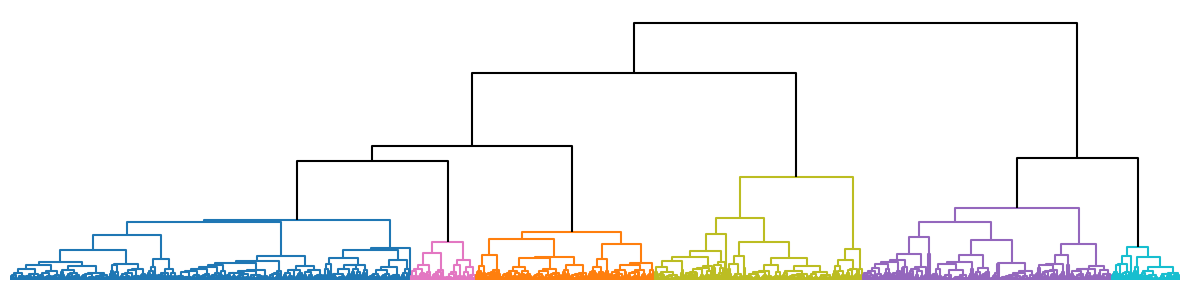

In [109]:
# Only dendrogram
fig = plt.figure(figsize=(12,3))
ax = plt.gca()
hierarchy.dendrogram(M2,
    color_threshold=threshold,
    distance_sort='descending',
    ax=ax,
    orientation='top',
    above_threshold_color='#000000'
)
ax.axis('off')

# Save and show
plt.tight_layout()
plt.savefig(export_dir+'distance.png',dpi=300, transparent=True)
plt.show()

# Grafiks 3: Klāsteru izvietojums
Principālā komponentu analīze uz pirmajiem diviem komponentiem. Šis dod ērtu veidu, kā parādīt

Constructing an array from the data
Mean-centering the data
Construting the sample covariance matrix
Computing eigenvalues
Top 1 eigvals have cumulative magnitude 40.3%
Top 2 eigvals have cumulative magnitude 68.94%
Top 3 eigvals have cumulative magnitude 79.72%
Projecting
Constructing new data matrix
Getting cluster labels from dendrogram
Plotting projections


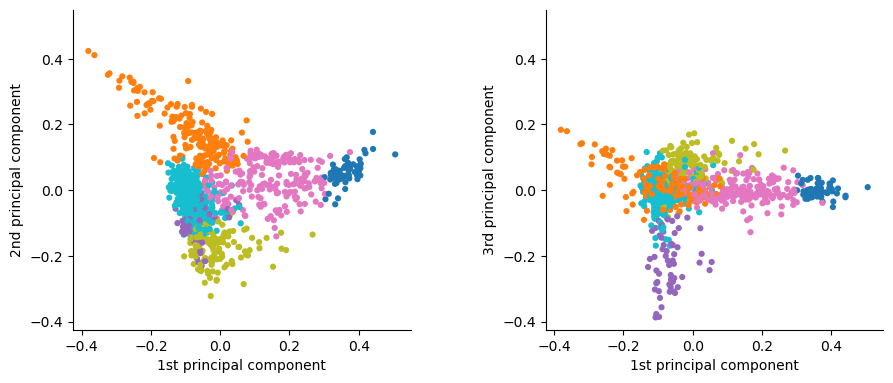

In [9]:
# Construct the data array
print('Constructing an array from the data', flush=True)
data = []
for df in [df_local_results,df_arzemes_results]:
    for row_index in range(df.shape[0]):
        current_row = df.iloc[row_index]
        current_results = []
        for partija in partijas:
            current_results.append(current_row[partija]/current_row['total_votes'])
        data.append(current_results)
data = np.array(data)
        
# Mean-center the data
print('Mean-centering the data', flush=True)
dataT = np.transpose(data)
sample_size = len(data)
means = []
for row in dataT:
    means.append(np.mean(row))
dataT_meancentered = np.array([[element-means[i] for element in row] for i,row in enumerate(dataT)])

# Construct the sample covariance matrix
print('Construting the sample covariance matrix', flush=True)
sample_cov = np.matmul(dataT_meancentered,np.transpose(dataT_meancentered))/(sample_size-1)

# Compute eigenvalues
print('Computing eigenvalues', flush=True)
U, s, VT = la.svd(sample_cov)
Uvecs = np.transpose(U)
Vvecs = VT
Svals = s

# Print cumulative eigenvalue magnitude
for i in [1,2,3]:
    print('Top '+str(i)+' eigvals have cumulative magnitude '+str(round(100*sum(Svals[:i])/sum(Svals),2))+'%')

# Project to chosen number of principal components
print('Projecting', flush=True)
components = 3
data_new = np.transpose(dataT_meancentered)
new_projections = {i:np.array([np.dot(sample,Uvecs[i])/np.dot(Uvecs[i],Uvecs[i]) for sample in data_new]) for i in range(components)}

# Construct new data matrix
print('Constructing new data matrix', flush=True)
data_projected = np.transpose(np.array([new_projections[i] for i in range(components)]))

# Cik klāsteri izvēlēti
print('Getting cluster labels from dendrogram', flush=True)
cluster_number = len(colors)
cluster_labels = hierarchy.fcluster(heat.dendrogram_col.linkage, cluster_number, criterion='maxclust')
cluster_indices = {i: [] for i in range(cluster_number)}
for i, label in enumerate(cluster_labels):
    cluster_indices[label-1].append(i)
index_clusters = {}
for key in cluster_indices:
    for item in cluster_indices[key]:
        index_clusters[item] = key

# Plot it
print('Plotting projections', flush=True)
fig,axes = plt.subplots(1,2,figsize=(9,4), facecolor='w')
axes[0].scatter(new_projections[0], new_projections[1], c=[colors[index_clusters[i]] for i in range(sample_size)],
           alpha=1, ec='none', s=20)
axes[0].set_xlabel('1st principal component')
axes[0].set_ylabel('2nd principal component')
axes[1].scatter(new_projections[0], new_projections[2], c=[colors[index_clusters[i]] for i in range(sample_size)],
           alpha=1, ec='none', s=20)
axes[1].set_xlabel('1st principal component')
axes[1].set_ylabel('3rd principal component')

for ax in axes:
    ax.set_ylim(axes[0].get_xlim())
    ax.set_xlim(axes[0].get_xlim())
    ax.spines[['top','right']].set_visible(False)

# Show
plt.subplots_adjust(wspace=.4, left=.09, right=.99, top=.95, bottom=.15)
plt.savefig(export_dir+'pca.png',dpi=300, transparent=False)
plt.show()

# Grafiks 4: Klāsteri un to apmeklētība
Šis norāda uz vēlētāju aktivitāti pēc klāstera. Dažos klāsteros iecirkņi bija salīdzinoši apmeklētāki nekā citos.

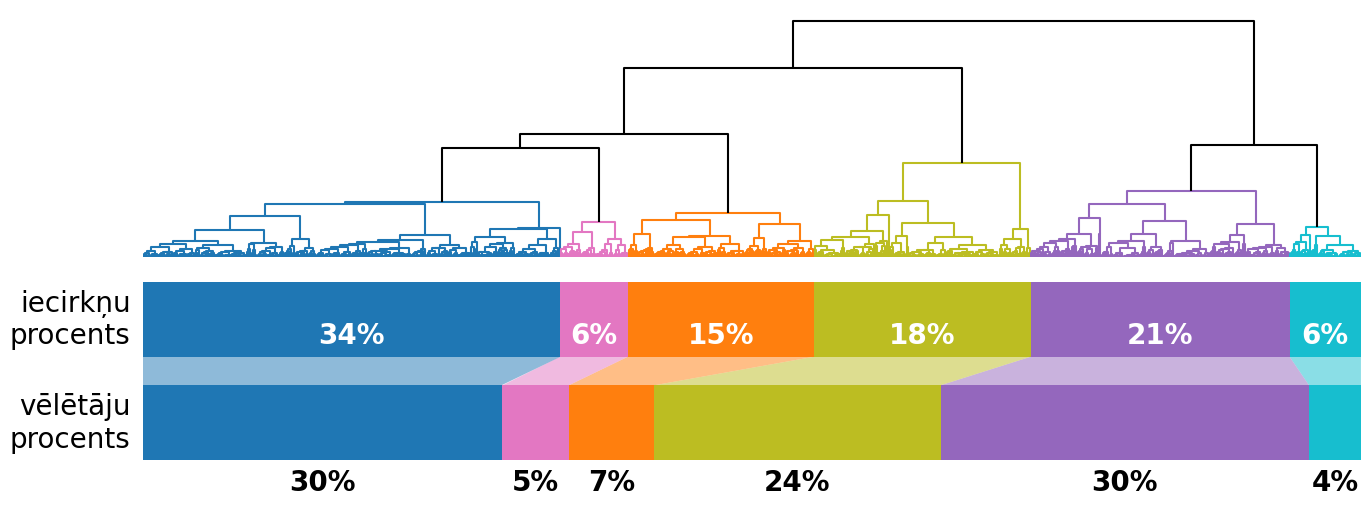

In [15]:
# Dendrogram and split bars
fig,axes = plt.subplots(3,1,figsize=(14,5),height_ratios=[3,1,1])

# Dendrogram
ax = axes[0]
hierarchy.dendrogram(M2,
    color_threshold=threshold,
    distance_sort='descending',
    ax=ax,
    orientation='top',
    above_threshold_color='#000000'
)

# Percentage: iecirkni
ax = axes[1]
total_length = sum([len(cluster_indices[i]) for i in range(cluster_number)])
total_sofar = 0
fraction_list = [0]
for i in range(cluster_number):
    current_fraction = len(cluster_indices[i])/total_length
    ax.barh(0, current_fraction, 1, left=total_sofar, color=colors_forplotting[i])
    ax.text(total_sofar+current_fraction/2, -.4, str(round(current_fraction*100))+'%', 
            ha='center', va='bottom', fontsize=20, fontweight='bold', color=(1,1,1)
           )

    total_sofar += current_fraction
    fraction_list.append(total_sofar)
ax.set_xlim([1,0])
ax.text(-.01,.5,'iecirkņu\nprocents', fontsize=20, ha='right', va='center', transform=ax.transAxes)

# Percentage: voters
ax = axes[2]
total_count = results_full['total_votes']
total_sofar = 0
for i in range(cluster_number):
    current_indices_local = [j for j in cluster_indices[i] if j<df_local_coords.shape[0]]
    current_indices_arzemes = [j-df_local_coords.shape[0] for j in cluster_indices[i] if j>=df_local_coords.shape[0]]
    current_count = 0
    for j in current_indices_local:
        current_count += df_local_results.iloc[j]['total_votes']
    for j in current_indices_arzemes:
        current_count += df_arzemes_results.iloc[j]['total_votes']    
    ax.barh(0, current_count, 1, left=total_sofar, color=colors_forplotting[i])
    ax.text(total_sofar+current_count/2, -.6, str(round(current_count/total_count*100))+'%',
            ha='center', va='top', fontsize=20, fontweight='bold'
           )

    # Connector
    shape = plt.Polygon([
        [total_sofar,.5],
        [total_sofar+current_count,.5],
        [fraction_list[i+1]*total_count,.88],
        [fraction_list[i]*total_count,.88]
        ],
        fc=colors_forplotting[i],zorder=-100, clip_on=False, alpha=.5)
    ax.add_artist(shape)
    
    total_sofar += current_count

ax.set_xlim([total_count,0])
ax.text(-.01,.5,'vēlētāju\nprocents', fontsize=20, ha='right', va='center', transform=ax.transAxes)

# Style
for ax in axes:
    ax.axis('off')

# Save and show
plt.subplots_adjust(hspace=.15, left=.11, right=.98, bottom = .07, top=.98)
plt.savefig(export_dir+'distance-split.png',dpi=300, transparent=False)
plt.show()

# Grafiks 5: Kuras partijas īpāši (ne)populāras klāsteros

In [43]:
# Comparison of groups to global

def groupplot(groupnumber, highlights, label, colortext=True, quiet=False):
    fig = plt.figure(figsize=(7,4))
    ax = plt.gca()
    meanradius=.3
    xmax = 0.55

    # Background
    barcolors = []
    for i in range(len(partijas)):
        if i in highlights:
            barcolors.append(colors_forplotting[groupnumber])
        else:
            barcolors.append((0,0,0))
    barlengths = [results_full[partija]/results_full['total_votes'] for partija in partijas]
    ax.bar(range(len(partijas)), barlengths, color=barcolors, alpha=.3)
    ax.set_xticks([])
    ax.set_ylim([0,xmax])
    ax.set_xlim([len(partijas)-.2,-.8])
            
    # Violinplots
    current_num = len(cluster_indices[groupnumber])
    distributions = []
    for j,partija in enumerate(partijas):
        current_distribution = []
        for index in cluster_indices[groupnumber]:
            try:
                current_place = df_local_results.iloc[index]
            except:
                current_place = df_arzemes_results.iloc[index-df_local_results.shape[0]]
            current_distribution.append(current_place[partija]/current_place['total_votes'])
        distributions.append(current_distribution)
    violins = ax.violinplot(distributions, positions=range(len(partijas)), widths=0.8,
                  showmeans=False, showextrema=True, vert=True
                 )
    
    # Means
    for i,distribution in enumerate(distributions):
        ax.plot([i-meanradius,i+meanradius],[np.mean(distribution)]*2,c=barcolors[i],lw=2)
        
    # Violin styles
    for i,pc in enumerate(violins['bodies']):
        if i in highlights:
            pc.set_facecolor(colors_forplotting[groupnumber])
            pc.set_alpha(.6)
        else:
            pc.set_facecolor((0,0,0,.3))
    violins['cmaxes'].set_colors([colors_forplotting[groupnumber] if i in highlights else (0,0,0,.3) for i in range(len(partijas))])
    violins['cmins'].set_colors([colors_forplotting[groupnumber] if i in highlights else (0,0,0,.3) for i in range(len(partijas))])
    violins['cbars'].set_colors([colors_forplotting[groupnumber] if i in highlights else (0,0,0,.3) for i in range(len(partijas))])
    violins['cmaxes'].set_segments([(
        (segment[0]+segment[1])/2-.25*(segment[1]-segment[0]),
        (segment[0]+segment[1])/2+.25*(segment[1]-segment[0])
            ) for segment in violins['cmaxes'].get_segments()])
    violins['cmins'].set_segments([(
        (segment[0]+segment[1])/2-.25*(segment[1]-segment[0]),
        (segment[0]+segment[1])/2+.25*(segment[1]-segment[0])
            ) for segment in violins['cmins'].get_segments()])
    
    # Changes in text and labels
    ax.set_xticks(range(len(partijas)))
    ax.set_xticklabels([partijas_nicenames[partija] for partija in partijas], ha='right', fontsize=10, rotation=45)
    if colortext:
        for i,barlength,distribution,xtick in zip(range(len(partijas)),barlengths,distributions,ax.get_xticklabels()):
            if i in highlights:
                xtick.set_color(colors_forplotting[groupnumber])
            else:
                xtick.set_alpha(.3)
    else:
        for xtick in ax.get_xticklabels():
            xtick.set_alpha(.3)
                                        
    # Style
    ax.spines[['left','top']].set_visible(False)
    ax.set_yticks([0,.1,.2,.3,.4,.5])
    ax.set_yticklabels(['0%','10%','20%','30%','40%','50%'])
    ax.yaxis.tick_right()
    
    # Save and show
    plt.tight_layout()
    plt.savefig(export_dir+'clusters_'+str(groupnumber)+'.png',dpi=300, transparent=True)
    
    if not quiet:
        plt.show()
    else:
        plt.close(fig)

## Piemēri

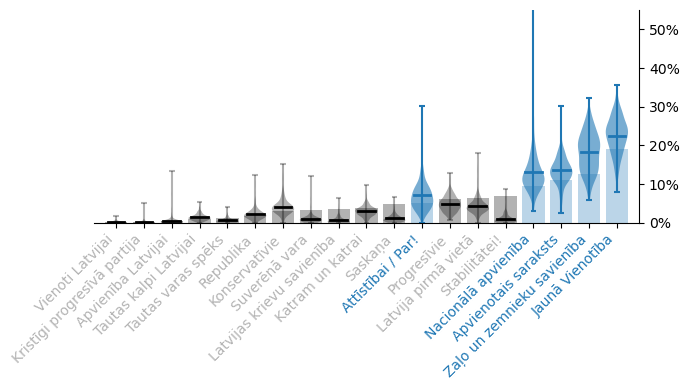

In [49]:
# groupplot(0,[4,8,10,11],'F') # [0,2,3,4,6,8,10,11])
# groupplot(1,[4,5,8,10],'B') # [0,2,4,5,8])
# groupplot(2,[0,6], 'G') # [0,1,6])
## groupplot(3,[0,6],'A')
# groupplot(3,[1,12],'E')
# groupplot(4,[1,2],'D')
groupplot(5,[0,1,2,3,7],'C')

# Grafiks 6: Latvijas rezultāti klāsteros

In [73]:
# Full cluster: Latvija
pointsize = 45

# groups is a list with 1 element or with 7 elements (all clusters)
def clusterdraw_lv(groups, quiet=True):
    # Initiate
    fig = plt.figure(figsize=(9.6,6))
    ax = plt.gca()
    
    # Set bounds
    xbuffer = .01
    ybuffer = .01
    xmin = min(boundary_forplotting[0])-xbuffer
    xmax = max(boundary_forplotting[0])+xbuffer
    ymin = min(boundary_forplotting[1])-ybuffer
    ymax = max(boundary_forplotting[1])+ybuffer
        
    # Draw
    # pos = ax.imshow(grid_latvija, extent=(xmin, xmax, ymax, ymin), aspect=1.6, cmap = plt.get_cmap('viridis'))#, vmin=0)
    if len(groups) == 1:
        current_colors = np.array([index_clusters[i] for i in range(df_local_coords.shape[0])])
        index_front = np.where(current_colors == groups[0])[0]
        current_colors_front = [colors_forplotting[groups[0]]]*len(index_front)
        index_back = np.array([i for i in range(len(current_colors)) if i not in index_front])
        current_colors_back = ['#DCDCDC' for i in index_back]

        ax.scatter(df_local_coords['lng'][index_back], df_local_coords['lat'][index_back], 
                   s=pointsize, color=current_colors_back, edgecolors='None')        
        ax.scatter(df_local_coords['lng'][index_front], df_local_coords['lat'][index_front], 
                   s=pointsize, color=current_colors_front, edgecolors='None')        
        
    else:
        current_colors = [colors_forplotting[index_clusters[i]] for i in range(df_local_coords.shape[0])]
        ax.scatter(df_local_coords['lng'], df_local_coords['lat'], s=pointsize, color=current_colors, edgecolors='None', zorder=2)
    
    # Style it
    ax.set_ylim([min(boundary_forplotting[1]), max(boundary_forplotting[1])])
    ax.axis('off')
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])
    
    # Novadi
    for novads in novadi_coordinates:
        novads_forplotting = np.transpose(np.array(novads))
        ax.plot(novads_forplotting[0], novads_forplotting[1], c=(.9,.9,.9), lw=1, zorder=-2)
    
    # Mask outside
    # mask_outside_polygon([tuple(k) for k in boundary], ax=ax)
    
    # Save and show
    if len(groups) == 1:
        filename = '_'+str(groups[0])
    else:
        filename = ''
    plt.tight_layout()
   
    if not quiet:
        plt.show()
    else:
        plt.savefig(export_dir+'lv_cluster'+filename+'.png',dpi=300)
        plt.close(fig)
        
for group in [[0,1,2,3,4,5],[0],[1],[2],[3],[4],[5]]:
    print('Drawing group '+str(group), flush=True)
    clusterdraw_lv(group)
print('All done', flush=True)

Drawing group [0, 1, 2, 3, 4, 5]
Drawing group [0]
Drawing group [1]
Drawing group [2]
Drawing group [3]
Drawing group [4]
Drawing group [5]
All done


## Piemērs

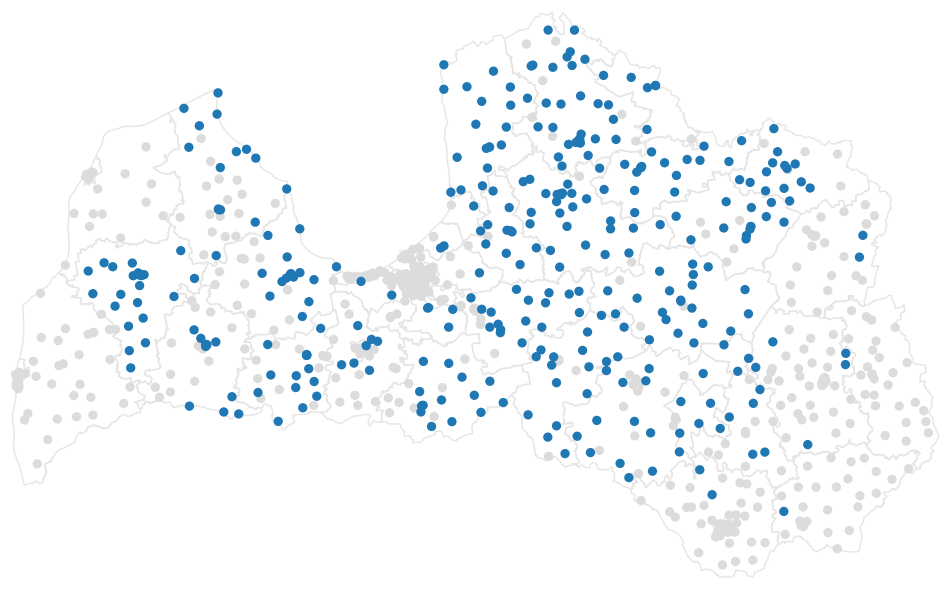

In [76]:
clusterdraw_lv([5],quiet=False)

# Grafiks 7: Ārzemju rezultāti klāsteros

In [77]:
continent_reverse_dict = {
    'NOVAODESA':'amerika',
    'AMERIKAS SAVIENOTĀS VALSTIS':'amerika',
    'BOSTONA':'amerika',
    'ČIKĀGA':'amerika',
    'DENVERA':'amerika',
    'INDIANAPOLE':'amerika',
    'KANĀDA':'amerika',
    'LOSANDŽELOSA':'amerika',
    'MILVOKI':'amerika',
    'MINEAPOLE':'amerika',
    'MONREĀLA':'amerika',
    'ŅUJORKA':'amerika',
    'OTAVA':'amerika',
    'SANFRANCISKO':'amerika',
    'SIETLA':'amerika',
    'TORONTO':'amerika',
    'VAŠINGTONA':'amerika',
    'VANKŪVERA':'amerika',

    'ABU DABI':'āzija',
    'ANKARA':'āzija',
    'APVIENOTIE ARĀBU EMIRĀTI':'āzija',
    'BAKU':'āzija',
    'JAPĀNA':'āzija',
    'KAZAHSTĀNA':'āzija',
    'KIŠIŅEVA':'āzija',
    'KOREJAS REPUBLIKA':'āzija',
    'NURSULTANA':'āzija',
    'ŅŪDELI':'āzija',
    'PEKINA':'āzija',
    'SEULA':'āzija',
    'TAŠKENTA':'āzija',
    'TBILISI':'āzija',
    'TELAVIVA':'āzija',
    'TOKIJA':'āzija',
    'TURCIJA':'āzija',
    
    'LONDONA':'britu salas',
    'NORTHAMPTONA':'britu salas',
    'BREDFORDA':'britu salas',
    'STRAUMĒNI':'britu salas',
    'GĒRNSIJA':'britu salas',
    'BRISTOLE':'britu salas',
    'DUBLINA':'britu salas',
    'SVONZI':'britu salas',
    'APVIENOTĀ KARALISTE':'britu salas',
    'ĪRIJA':'britu salas',

    'ATĒNAS':'eiropa',
    'BRISELE':'eiropa',
    'KOPENHĀGENA':'eiropa',
    'MASKAVA':'eiropa',
    'PARĪZE':'eiropa',
    'PRĀGA':'eiropa',
    'ROMA':'eiropa',
    'TALLINA':'eiropa',
    'VITEBSKA':'eiropa',
    'VĪNE':'eiropa',
    'VAILE':'eiropa',
    'STRASBŪRA':'eiropa',
    'VIĻŅA':'eiropa',
    'HĀGA':'eiropa',
    'OSLO':'eiropa',
    'VARŠAVA':'eiropa',
    'REIKJAVĪKA':'eiropa',
    'MADRIDE':'eiropa',
    'HELSINKI':'eiropa',
    'CĪRIHE':'eiropa',
    'KIJEVA':'eiropa',
    'BERLĪNE':'eiropa',
    'MINSTERE':'eiropa',
    'STOKHOLMA':'eiropa',
    'BERGENA':'eiropa',
    'BUDAPEŠTA':'eiropa',
    'STAVANGERE':'eiropa',
    'VALENSIJA':'eiropa',
    'DISELDORFA':'eiropa',
    'LUKSEMBURGA':'eiropa',
    'FRANKFURTE PIE MAINAS':'eiropa',
    'FREIBURGA':'eiropa',
    'HAMBURGA':'eiropa',
    'BRĒMENE':'eiropa',
    'LEONBERGA':'eiropa',
    'AUSTRIJA':'eiropa',
    'BALTKRIEVIJA':'eiropa',
    'DĀNIJA':'eiropa',
    'FRANCIJA':'eiropa',
    'NĪDERLANDE':'eiropa',
    'NORVĒĢIJA':'eiropa',
    'POLIJA':'eiropa',
    'SPĀNIJA':'eiropa',
    'SOMIJA':'eiropa',
    'VĀCIJA':'eiropa',
    'ZVIEDRIJA':'eiropa',
    
    'ADELAIDE':'okeānija',
    'MELBURNA':'okeānija',
    'SIDNEJA':'okeānija',
    'PĒRTA':'okeānija',
    'BRISBENA':'okeānija',
    'KANBERA':'okeānija',
    'AUSTRĀLIJA':'okeānija',

'KAIRA':'āfrika',
'ĒĢIPTE':'āfrika',
'TENERIFE':'āfrika'
}

continents = ['eiropa', 'amerika', 'āzija', 'britu salas', 'okeānija', 'āfrika']
continent_dict = {c:[] for c in continents}
for key in continent_reverse_dict.keys():
    continent_dict[continent_reverse_dict[key]].append(key)
    
# Collect data
values = {c:[] for c in continents}
indices = {c:[] for c in continents}
for row_index in range(df_arzemes_results.shape[0]):
    current_row = df_arzemes_results.iloc[row_index]
    current_name = current_row['Name'].split('(')[-1][:-1]
    
    # Kosovo exception
    if current_name.count(' ')>2:
        current_continent = 'eiropa'
    else:
        current_continent = continent_reverse_dict[current_name]     
    values[current_continent].append(M_arzemes[0][row_index+1])
    indices[current_continent].append(row_index)

In [144]:
continent_dict['britu salas']

['LONDONA',
 'NORTHAMPTONA',
 'BREDFORDA',
 'STRAUMĒNI',
 'GĒRNSIJA',
 'BRISTOLE',
 'DUBLINA',
 'SVONZI',
 'APVIENOTĀ KARALISTE',
 'ĪRIJA']

In [139]:
df_arzemes_results.shape

(104, 26)

In [164]:
# Full cluster - arzemes
pointsize = 35

# groups is a list with 1 element or with 7 elements (all clusters)
def clusterdraw_arzemes(groups, quiet=False):
    # Initiate
    fig, axes = plt.subplots(6,1,figsize=(3,4))
    rownum = 3

    # Draw
    for i,continent in enumerate(continents):
        ax = axes[i]
        current_indices = indices[continent]
        current_colors = []
        
        # Get colors for each iecirknis
        for value in indices[continent]:
            current_cluster = index_clusters[value+df_local_results.shape[0]]
            if current_cluster in groups:
                current_colors.append(colors_forplotting[current_cluster])
            else:
                current_colors.append('#DCDCDC')
                
        # Plot 
        ax.scatter(
            [j//rownum for j in range(len(current_indices))],
            [rownum-j%rownum-1 for j in range(len(current_indices))],
            s=pointsize,
            color=current_colors)
#         for x,y,s,k in zip(
#             [j//rownum for j in range(len(current_indices))],
#             [rownum-j%rownum-1 for j in range(len(current_indices))],
#             df_arzemes_results.iloc[current_indices]['Name'],
#             range(len(current_indices))):
#             if k in [n+9 for n in [0,1,2]]:
#                 ax.text(x,y,s,ha='left',va='bottom',fontsize=6)
        
    # Style
    for ax in axes:
        ax.spines[['right', 'left','top','bottom']].set_visible(False)
        ax.set_ylim([-.5,rownum-.5])
        ax.set_yticks([])
        ax.set_xlim([-.5,15.5])
        ax.set_xticks([])
    
    # Save and show
    if len(groups) == 1:
        filename = '_'+str(groups[0])
    else:
        filename = ''
    plt.tight_layout()

    if not quiet:
        plt.show()
    else:
        plt.savefig(export_dir+'arzemes_cluster'+filename+'.png',dpi=300, transparent=True)
        plt.close(fig)
    
for group in [[0,1,2,3,4,5],[0],[1],[2],[3],[4],[5]]:
    print('Drawing group '+str(group), flush=True)
    clusterdraw_arzemes(group, quiet=True)
print('All done', flush=True)

Drawing group [0, 1, 2, 3, 4, 5]
Drawing group [0]
Drawing group [1]
Drawing group [2]
Drawing group [3]
Drawing group [4]
Drawing group [5]
All done


## Piemērs

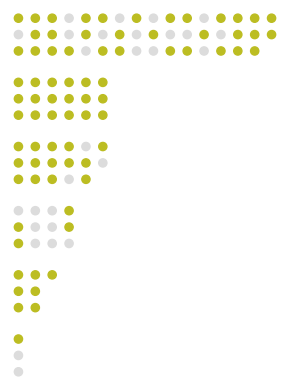

In [80]:
clusterdraw_arzemes([2],quiet=False)

# Grafiks 8: Rīgas rezultāti klāsteros

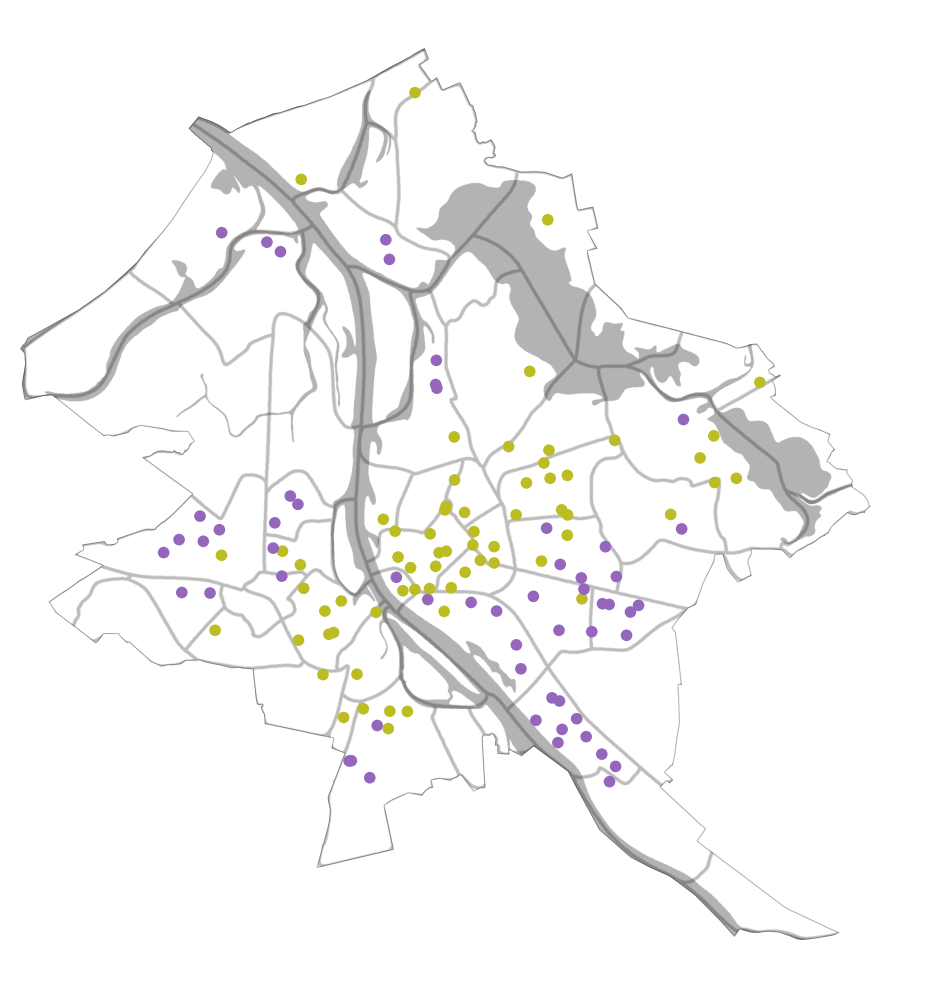

In [26]:
# Full cluster - Riga
pointsize = 70

# Initiate
fig = plt.figure(figsize=(10,10))
ax = plt.gca()

# Set bounds
xbuffer = .01
ybuffer = .01
xmin = min(riga_forplotting[0])-xbuffer
xmax = max(riga_forplotting[0])+xbuffer
ymin = min(riga_forplotting[1])-ybuffer
ymax = max(riga_forplotting[1])+ybuffer
riga_indices = np.array(
    [i for i in range(df_local_coords.shape[0]) if (
                (df_local_coords.iloc[i]['lng']>xmin) and
                (df_local_coords.iloc[i]['lng']<xmax) and
                (df_local_coords.iloc[i]['lat']>ymin) and
                (df_local_coords.iloc[i]['lat']<ymax)
)])
riga_max = max(M_local[0][1:][riga_indices])
riga_min = min(M_local[0][1:][riga_indices])

# Draw 
# pos = ax.imshow(grid_riga, extent=(xmin, xmax, ymax, ymin), cmap = plt.get_cmap('viridis'))#, vmin=0)
ax.scatter(
    [df_local_coords.iloc[i]['lng'] for i in riga_indices],
    [df_local_coords.iloc[i]['lat'] for i in riga_indices],
    s=pointsize,
    color=[colors_forplotting[index_clusters[i]] for i in riga_indices],
    alpha=1,
    edgecolors='None',
    zorder=4
)

# # Labels
# for i in riga_indices:
#     ax.text(df_local_coords.iloc[i]['lng'], df_local_coords.iloc[i]['lat'], str(i), ha='left', va='bottom')

# Style it
ax.set_ylim([ymin,ymax])

# Mask outside
mask_outside_polygon([tuple(k) for k in riga[::-1]])
ax.plot(riga_forplotting[0], riga_forplotting[1], zorder=-2, c=(0,0,0,.3))

# Background: udens
# https://apkaimes.lv/
img = plt.imread("apkaimes-udens-melns.png")
ax.imshow(img, extent=[xmin-0.087, xmax+0.109, ymin+0.005, ymax+0.004], alpha=.3, aspect='1.8', zorder=2)

# Background: apkaimju robezas
# https://apkaimes.lv/
img = plt.imread("apkaimes-outlines.png")
ax.imshow(img, extent=[xmin-0.087, xmax+0.109, ymin+0.005, ymax+0.004], alpha=.3, aspect='1.8', zorder=3)

# Style
ax.axis('off')

# Save and show
plt.tight_layout()
plt.savefig(export_dir+'rix_cluster.png',dpi=300, transparent=True)
plt.show()

# Grafiks 9: Rīgas rezultāti apvienoti pa klāsteriem

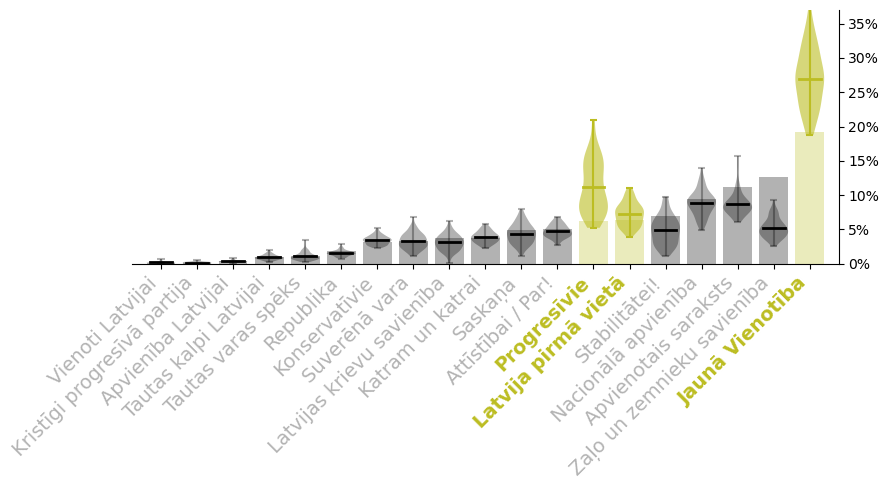

In [37]:
# Indices within rectangle, but outside Riga
drop = [528,771,562,468,355,854,398,752,430,828,651,776,765,473,422,409,351]
true_riga = np.array([i for i in riga_indices if i not in drop])

groupnumber = 1
highlights = [4,5,8,9,10,11]

groupnumber = 2
highlights = [0,5,6]

true_riga = np.array([i for i in true_riga if i in cluster_indices[groupnumber]])

# Initiate
fig = plt.figure(figsize=(9,5))
ax = plt.gca()
meanradius=.3
xmax = 0.55

# Background
barcolors = []
for i in range(len(partijas)):
    if i in highlights:
        barcolors.append(colors_forplotting[groupnumber])
    else:
        barcolors.append((0,0,0))
barlengths = [results_full[partija]/results_full['total_votes'] for partija in partijas]
ax.bar(range(len(partijas)), barlengths, color=barcolors, alpha=.3)
ax.set_xticks([])
ax.set_xlim([len(partijas)-.2,-.8])

# Violinplot
distributions = [[df_local_results.iloc[i][partija]/df_local_results.iloc[i]['total_votes'] for i in true_riga] for partija in partijas]
violins = ax.violinplot(distributions, positions=range(len(partijas)), widths=0.8,
                  showmeans=False, showextrema=True, vert=True
                 )
# Means
for i,distribution in enumerate(distributions):
    ax.plot([i-meanradius,i+meanradius],[np.mean(distribution)]*2,c=barcolors[i],lw=2)

# Violin styles
for i,pc in enumerate(violins['bodies']):
    if i in highlights:
        pc.set_facecolor(colors_forplotting[groupnumber])
        pc.set_alpha(.6)
    else:
        pc.set_facecolor((0,0,0,.3))
violins['cmaxes'].set_colors([colors_forplotting[groupnumber] if i in highlights else (0,0,0,.3) for i in range(len(partijas))])
violins['cmins'].set_colors([colors_forplotting[groupnumber] if i in highlights else (0,0,0,.3) for i in range(len(partijas))])
violins['cbars'].set_colors([colors_forplotting[groupnumber] if i in highlights else (0,0,0,.3) for i in range(len(partijas))])
violins['cmaxes'].set_segments([(
    (segment[0]+segment[1])/2-.25*(segment[1]-segment[0]),
    (segment[0]+segment[1])/2+.25*(segment[1]-segment[0])
        ) for segment in violins['cmaxes'].get_segments()])
violins['cmins'].set_segments([(
    (segment[0]+segment[1])/2-.25*(segment[1]-segment[0]),
    (segment[0]+segment[1])/2+.25*(segment[1]-segment[0])
        ) for segment in violins['cmins'].get_segments()])
    
# Style
ax.spines[['left','top']].set_visible(False)
ax.set_ylim([0,.37])
ax.set_yticks([0,.05,.1,.15,.2,.25,.3,.35])
ax.set_yticklabels(['0%','5%','10%','15%','20%','25%','30%','35%'])
ax.yaxis.tick_right()

# Labels
ax.set_xticks(range(len(partijas)))
ax.set_xticklabels([partijas_nicenames[partija] for partija in partijas], ha='right', fontsize=14, rotation=45)
for i,barlength,distribution,xtick in zip(range(len(partijas)),barlengths,distributions,ax.get_xticklabels()):
    if i in highlights:
        xtick.set_color(colors_forplotting[groupnumber])
        xtick.set_fontweight('bold')
    else:
        xtick.set_alpha(.3)

# Save and show
plt.tight_layout()
plt.savefig(export_dir+'riga_cluster_'+str(groupnumber)+'.png',dpi=300, transparent=True)
plt.show()

# Grafiks 10: Latvijas rezultāti attālumā

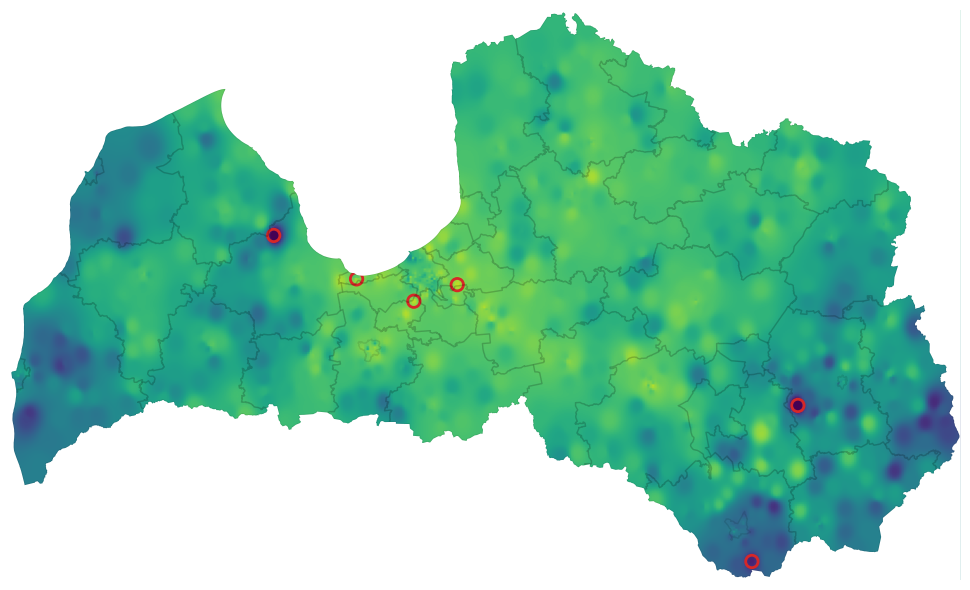

In [11]:
# Set bounds
xbuffer = .01
ybuffer = .01
xmin = min(boundary_forplotting[0])-xbuffer
xmax = max(boundary_forplotting[0])+xbuffer
ymin = min(boundary_forplotting[1])-ybuffer
ymax = max(boundary_forplotting[1])+ybuffer

# Define data
x = df_local_coords['lng']
y = df_local_coords['lat']
z = np.array([local_max-k for k in M_local[0][1:]])
xstep = 400
ystep = 300
xi = np.linspace(xmin, xmax, xstep)
yi = np.linspace(ymin, ymax, ystep)

# Adapt data
xi, yi = np.meshgrid(xi, yi)
xi, yi = xi.flatten(), yi.flatten()
grid_latvija = simple_idw(x,y,z,xi,yi, power=3)
grid_latvija = grid_latvija.reshape((ystep, xstep))
    
# Draw it
fig = plt.figure(figsize=(10,6))
ax = plt.gca()
pos = ax.imshow(
    grid_latvija,
    extent=(xmin, xmax, ymax, ymin),
    aspect=1.8,
    cmap = plt.get_cmap('viridis'),
    vmin=local_min,
    vmax=local_max
)

# Highlights
select = 3
toplist = np.argsort(M_local[0][1:])
ax.scatter(df_local_coords['lng'][toplist[:select]], df_local_coords['lat'][toplist[:select]],
           edgecolors='C3', facecolors='none', s=80, lw=2
          )
ax.scatter(df_local_coords['lng'][toplist[-select:]], df_local_coords['lat'][toplist[-select:]],
           edgecolors='C3', facecolors='none', s=80, lw=2
          )

# Style it
ax.set_ylim([min(boundary_forplotting[1]), max(boundary_forplotting[1])])
ax.axis('off')
ax.set_xlim([xmin,xmax])
ax.set_ylim([ymin,ymax])

# Novadi
for novads in novadi_coordinates:
    novads_forplotting = np.transpose(np.array(novads))
    ax.plot(novads_forplotting[0], novads_forplotting[1], c=(0,0,0), alpha=.1, lw=1)

# Mask outside
mask_outside_polygon([tuple(k) for k in boundary])

# Colorbar
# fig.colorbar(pos, ax=ax, shrink=.4)

# Save and show
plt.tight_layout()
plt.savefig(export_dir+'lv_idw.png',dpi=300)
plt.show()

# Grafiks 11: Ārzemju rezultāti

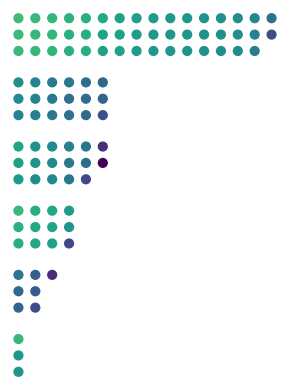

In [178]:
# Initiate
fig, axes = plt.subplots(6,1,figsize=(3,4))
rownum = 3

# Collect data
values = {c:[] for c in continents}
indices = {c:[] for c in continents}
for row_index in range(df_arzemes_results.shape[0]):
    current_row = df_arzemes_results.iloc[row_index]
    current_name = current_row['Name'].split('(')[-1][:-1]
    
    # Kosovo exception
    if current_name.count(' ')>2:
        current_continent = 'eiropa'
    else:
        current_continent = continent_reverse_dict[current_name]     
    values[current_continent].append(M_arzemes[0][row_index+1])
    indices[current_continent].append(row_index)

# Draw
for i,continent in enumerate(continents):
    ax = axes[i]
    current_places = continent_dict[continent]
    current_indices = indices[continent]  
    current_values = values[continent]
    current_order = np.argsort(current_values)
    current_values.sort()
    
    # Plot
    ax.scatter(
        [i//rownum for i in range(len(current_values))],
        [rownum-i%rownum-1 for i in range(len(current_values))],
        s=40,
        color=[plt.get_cmap('viridis')(full_max-value) for value in current_values]) 
#     for x,y,s,k in zip(
#         [j//rownum for j in range(len(current_indices))],
#         [rownum-j%rownum-1 for j in range(len(current_indices))],
#         np.array(df_arzemes_results.iloc[current_indices]['Name'])[current_order],
#         range(len(current_indices))):
#         if k in [n+3 for n in [0,1,2]]:
#             ax.text(x,y,s,ha='left',va='bottom',fontsize=6)

# Style
for ax in axes:
    ax.spines[['right', 'left','top','bottom']].set_visible(False)
    ax.set_ylim([-.5,rownum-.5])
    ax.set_yticks([])
    ax.set_xlim([-.5,15.5])
    ax.set_xticks([])


# Save and show
plt.tight_layout()
#plt.subplots_adjust(hspace=.5)
plt.savefig(export_dir+'arzemes_idw.png',dpi=300, transparent=True)
plt.show()

# Grafiks 12: Īpašu iecirkņu rezultāti

In [24]:
# Comparison of groups to global

def specialplot(index, ymax=.21, quiet=False):
    fig = plt.figure(figsize=(10,5))
    ax = plt.gca()
    xmax = 0.6

    # Background
    barlengths = [results_full[partija]/results_full['total_votes'] for partija in partijas]
    ax.bar(range(len(partijas)), barlengths, color=(.5,.5,.5), zorder=2)
    ax.set_xticks([])
    ax.set_ylim([0,ymax])
    ax.set_xlim([len(partijas)-.2,-.8])  
    
    # Foreground
    current_row = df_local_results.iloc[index]
    barlengths_main = [current_row[partija]/current_row['total_votes'] for partija in partijas]
    ax.bar(range(len(partijas)), barlengths_main, alpha=1, width=.5, color='C3', zorder=2)
    
    # Changes in text and labels
    ax.set_xticks(range(len(partijas)))
    ax.set_xticklabels([partijas_nicenames[partija] for partija in partijas], ha='right', fontsize=15, rotation=45, alpha=.5)
                                
    # ax.text(.6,len(partijas)-1,'Cluster '+label, fontweight='bold', color=colors_forplotting[groupnumber], fontsize=20, ha='right')
        
    # Style
    ax.spines[['left','top']].set_visible(False)
    # ax.set_yticks([0,.2,.4,.6])
    # ax.set_yticklabels(['0%','20%','40%','60%'])
    ax.yaxis.tick_right()
    # for y in [3,6,9,12,15]:
    #     ax.axhline(y+.5, linestyle='-', color=(0,0,0,.1), lw=1, )
    ax.grid(axis='y', zorder=-2)
    
    # Izņēmums Olaines garam nosaukumam
    if index == 398:
        ax.text(0,.93,'OLAINES SOCIĀLĀ DIENESTA CENTRS "GAISMAS"',ha='left',va='center', fontsize=15, fontweight='bold',
                transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='None'))
    else:
        ax.text(0,.93,df_local_results.iloc[index]['nosaukums'],ha='left',va='center', fontsize=15, fontweight='bold',
                transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='None'))
    
    # Adrese un balsu skaits
    ax.text(0,.81,df_local_results.iloc[index]['adrese'],ha='left',va='center', fontsize=15,
            transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='None'))
    ax.text(0,.69,str(df_local_results.iloc[index]['total_votes'])+' balsis',ha='left',va='center', fontsize=15,
            transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='None'), c=(.5,.5,.5))
    
    # Save and show
    plt.tight_layout()
    if not quiet:
        plt.show()
    else:
        plt.savefig(export_dir+'special_'+str(index)+'.png',dpi=300, transparent=True)
        plt.close(fig)
        
for index in toplist[:select]:
    print('Drawing iecirknis '+str(index), flush=True)
    specialplot(index, quiet=True)
for index in toplist[-select:]:
    print('Drawing iecirknis '+str(index), flush=True)
    specialplot(index, ymax=.62, quiet=True)
print('All done', flush=True)

Drawing iecirknis 398
Drawing iecirknis 731
Drawing iecirknis 746
Drawing iecirknis 822
Drawing iecirknis 52
Drawing iecirknis 578
All done


# Piemērs

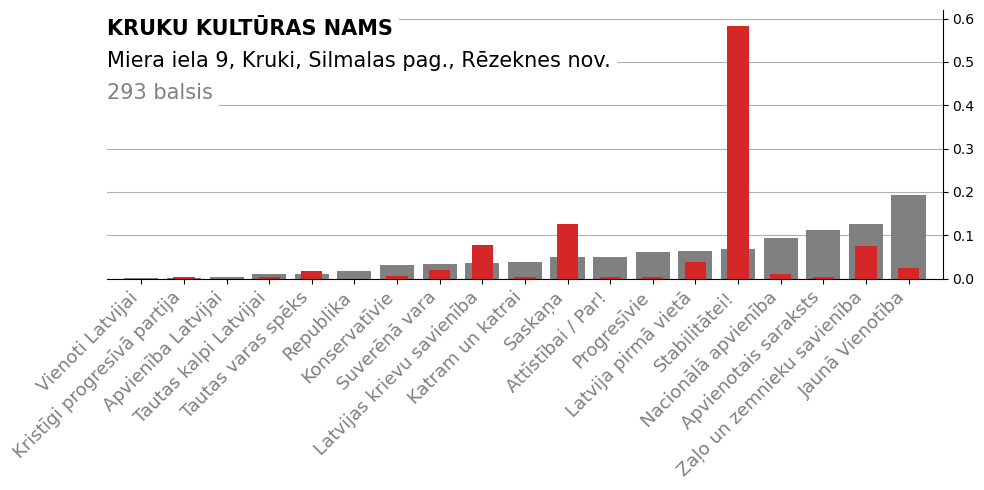

In [23]:
specialplot(578,ymax=.62)

# Grafiks 13: Attālums līdz vidējam

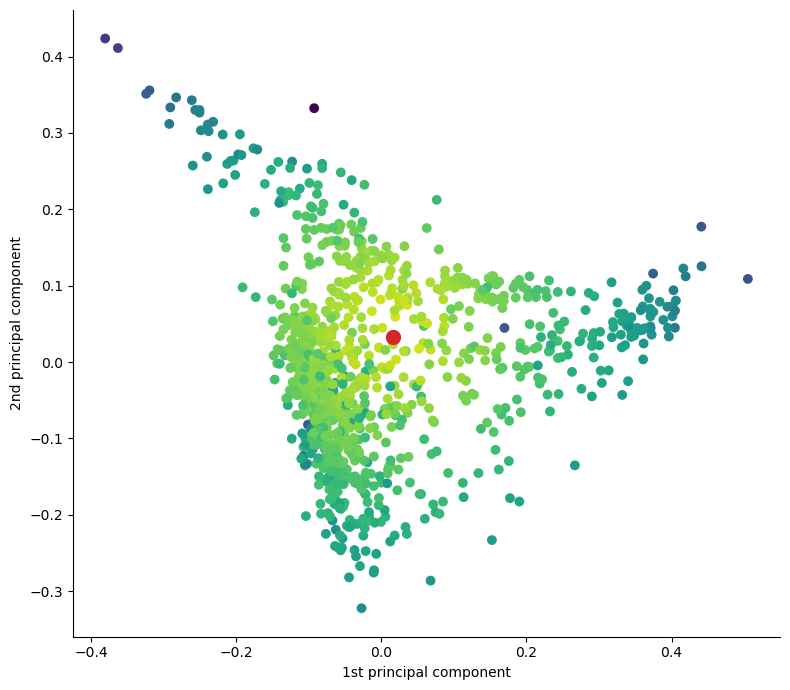

In [195]:
# Initiate
fig = plt.figure(figsize=(8,7), facecolor='w')
ax = plt.gca()

# Plot
ax.scatter(new_projections[0], new_projections[1],
           c=[plt.get_cmap('viridis_r')(k/max(M_full[0][1:])) for k in M_full[0][1:]],
           alpha=1, ec='none', s=50)
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')

# Full results
vec19 = np.array([results_full[partija]/results_full['total_votes'] for partija in partijas])
vec19_meancentered = np.array([vec19[i]-means[i] for i in range(len(vec19))])
x = np.dot(vec19_meancentered,Uvecs[0])/np.dot(Uvecs[0],Uvecs[0])
y = np.dot(vec19_meancentered,Uvecs[1])/np.dot(Uvecs[1],Uvecs[1])
ax.scatter([x],[y],c=['C3'],s=100)

# Style
ax.spines[['top','right']].set_visible(False)

# Show
plt.tight_layout()
plt.savefig(export_dir+'distance-to-all.png',dpi=300, transparent=False)
plt.show()

# Papildus: kā dabūt adreses no Zemes Dienesta adrešu reģistra

## Create list of unique iecirkņi and get coords

In [9]:
# Filter local and arzemes
arzemes = []
local = []
for i,entry in enumerate(data):
    current_department = entry['Department']
    if 'Address' in current_department:
        if current_department['ParentId'] == 'arzemes':
            arzemes.append(i)
        else:
            local.append(i)
print('Atrasti '+str(len(local))+' iecirkņi Latvijā', flush=True)
print('Atrasti '+str(len(arzemes))+' iecirkņi ārzemēs\n', end='-'*20+'\n', flush=True)
            
# Set up
adreses = np.unique(np.array([entry['Department']['Address'] for i,entry in enumerate(data) if i in local]))
adreses_loc_dict = {'adrese':[], 'x-lks-92':[], 'y-lks-92':[]}

# Go through addresses
print('Lasa '+str(len(adreses))+' unikālas Latvijas iecirkņu adreses\n'+'-'*20, end='', flush=True)
count_misspelling = 0; indices_misspelling = []
count_caseinsensitive = 0; indices_caseinsensitive = []
count_propersubstring = 0; indices_propersubstring = []
count_missing = 0; indices_missing = []
for i,address in enumerate(adreses):
    missing = True
    if i%10 == 0:
        if i%1000 == 0:
            print('', flush=True)
        print(i, end=' ', flush=True)
        
    # Fix symbol errors
    adreses_loc_dict['adrese'].append(address)
    temp = address
    if 'Jaunpagasts' not in address:
        address = address.replace('pagasts','pag.').replace('novads','nov.')  # saīsinājumi
    address = address.replace('“','"').replace('”','"')                       # vienādas pēdiņas
    address = address.lstrip().rstrip()                                       # whitespace sākumā un beigās
    address = address.replace('  ',' ')                                       # whitespace pa vidu
    if temp != address:
        count_misspelling += 1
        indices_misspelling.append(i)
    
    # Case-sensitive
    current_indices = [j for j,loc in enumerate(shapefile['STD'].array) if address in loc]   
    if len(current_indices) == 1:
        current_geometry = tuple(shapefile.iloc[current_indices[0]]['geometry'].coords[0])
        adreses_loc_dict['x-lks-92'].append(current_geometry[0])
        adreses_loc_dict['y-lks-92'].append(current_geometry[1])
        missing = False
        
    else:  
        # Case-insensitive
        current_indices = [j for j,loc in enumerate(shapefile['STD'].array) if address.lower() in loc.lower()]
        if len(current_indices) == 1:
            current_geometry = tuple(shapefile.iloc[current_indices[0]]['geometry'].coords[0])
            adreses_loc_dict['x-lks-92'].append(current_geometry[0])
            adreses_loc_dict['y-lks-92'].append(current_geometry[1])
            count_caseinsensitive += 1
            indices_caseinsensitive.append(i)
            missing = False
        
        if missing:
            # Case-sensitive and first letter sensitive
            current_indices = [j for j,loc in enumerate(shapefile['STD'].array) if ((address in loc) and (address[0] == loc[0]))]
            if len(current_indices) == 1:
                current_geometry = tuple(shapefile.iloc[current_indices[0]]['geometry'].coords[0])
                adreses_loc_dict['x-lks-92'].append(current_geometry[0])
                adreses_loc_dict['y-lks-92'].append(current_geometry[1])
                count_propersubstring += 1
                indices_propersubstring.append(i)
                missing = False
       
    if missing:
        print('', flush=True)
        print(str(len(current_indices))+' rindas', end=': ', flush=True)
        print(address, flush=True)
        adreses_loc_dict['x-lks-92'].append(0)
        adreses_loc_dict['y-lks-92'].append(0)
        count_missing += 1
        indices_missing.append(i)

print('\n'+'-'*20+'\nAtrastas koordinātas '+str(len(adreses)-count_missing)+' no '+str(len(adreses))+' adresēm', flush=True)
print('-'*20+'\nIzlabotas '+str(count_misspelling)+' adreses ar drukas klūdām', flush=True)
print('Atrastas '+str(count_caseinsensitive)+' adreses, kuram ir vienādi burti bet atšķirīgi lielumi', flush=True)
print('Atrastas '+str(count_propersubstring)+' adreses, kas atkārtojas atšķirīgiem priedēkļiem', flush=True)
print('Vēl trūkst koordinātas '+str(count_missing)+' adresēm')
print('All done', flush=True)

Atrasti 951 iecirkņi Latvijā
Atrasti 104 iecirkņi ārzemēs
--------------------
Lasa 903 unikālas Latvijas iecirkņu adreses
--------------------
0 10 
0 rindas: "Bangas"-2, Priedaine, Kurmāles pag., Kuldīgas nov.
20 30 40 50 
0 rindas: "Irbes"-1, Vienība, Degoles pag., Tukuma nov.
60 
0 rindas: "Jāņukalna Tautas Nams", Jāņukalns, Kalsnavas pag., Madonas nov.
70 80 90 100 110 
0 rindas: "Ozoli"-1, Kaļķi, Dundagas pag., Talsu nov.
120 130 140 150 
0 rindas: "Pilskalni", Launkalne, Launkalnes pag., Smiltenes nov.
160 
0 rindas: "Pīlādzīši", Spuņciems, Salas pag., Mārupes nov.

0 rindas: "Ritmi", Gavieze, Gaviezes pag., Dienvidkurzemes nov.

0 rindas: "Rude"-5, Rude, Rojas pag., Talsu nov.
170 180 190 200 
0 rindas: "Tautas Nams", Meņģeles pag., Ogres nov.
210 
0 rindas: "Tomes Tautas nams", Tomes pag., Ogres nov.
220 230 240 250 260 270 280 
0 rindas: Audupes iela 15/17, Rīga
290 300 310 320 330 340 350 360 
0 rindas: Detlava Brantkalna iela 5, Rīga
370 380 
0 rindas: Dārzu iela 37-3A, Rēz

## Fix missing

In [10]:
# Set up
missing_adreses = [a for i,a in enumerate(adreses) if adreses_loc_dict['x-lks-92'][i] == 0]
missing_adreses_index = {a:0 for a in missing_adreses}

## Manuāls darbs

In [11]:
fixed = 0

##
## 1/4
##

# Tautas nams / Kultūras nams, citāds formatējums
key = 'Kārķu tautas nams, Kārķi, Kārķu pag., Valkas nov.'
value = 185632
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Vecais pagasta nams / tautas nams
key = '"Jāņukalna Tautas Nams", Jāņukalns, Kalsnavas pag., Madonas nov.'
value = 425962
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# "Kultūras nams" nebija adresē
key = 'Loja, Sējas pag., Saulkrastu nov.'
value = 472087
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Nebija apdzīvotā vieta "Menģele" adresē
key = '"Tautas Nams", Meņģeles pag., Ogres nov.'
value = 485869
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Nebija apdzīvotā vieta "Tome" adresē
key = '"Tomes Tautas nams", Tomes pag., Ogres nov.'
value = 158867
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

print('Labotas '+str(fixed)+' kultūras namu adreses', flush=True)
fixed = 0

##
## 2/4
##

# Adrese "Pilskalni" neeksistē, savienoju ar Launkalnes tautas namu
# https://smiltenes-novada-pasvaldiba-launkalnes-pagasta-par-c-9710.kontakti.lv/lv/
key = '"Pilskalni", Launkalne, Launkalnes pag., Smiltenes nov.'
value = 286079
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Adrese "Pīlādzīši" neeksistē, savienoju ar Salas pamatskolu
# http://www.viss.lv/?p=166186
key = '"Pīlādzīši", Spuņciems, Salas pag., Mārupes nov.'
value = 313440
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Adrese "Zvārtas iela 6" neeksistē, Zvārtas iela 8 ir tajā pašā ēkā
# https://kulturasdati.lv/lv/bibliotekas/cesu-novada-drabesu-pagasta-livu-biblioteka
# https://web.archive.org/web/20230529025557/https://kulturasdati.lv/lv/bibliotekas/cesu-novada-drabesu-pagasta-livu-biblioteka
key = 'Zvārtas iela 6, Līvi, Drabešu pag., Cēsu nov.'
value = 287611
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Alsunga ir Kuldīgas novadā, nevis Alsungas novadā. Alsungas novads vairs neeksistē.
key = 'Ziedulejas iela 1, Alsunga, Alsungas pag., Alsungas nov.'
value = 43668
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Ģikši ir Cēsu novadā, nevis Amatas novadā. Amatas novads vairs neeksistē
key = 'Egļu iela 1, Ģikši, Amatas pag., Amatas nov.'
value = 286897
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Ape ir Smiltenes novadā, nevis Alūksnes novadā
key = 'Skolas iela 4, Ape, Alūksnes nov.'
value = 120378
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Adrese "Lībiesu iela 2" neeksistē, Google Maps rāda to un "Centra laukums 2" kā vienu un to pašu ēku
key = 'Lībiešu iela 2, Ikšķile, Ogres nov.'
value = 144150
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Adrese "Audupes iela 15/17" neeksistē. Vietu sauc "Sporta klubs prestol", kam ir reģistrēta adrese Traleru ielā 20
# https://www.prestolboats.com/contact-us
key = 'Audupes iela 15/17, Rīga'
value = 505505
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Adrese "Ritmi" neeksistē. Tas izskatās pēc pasta, bet pasta nav. Tuvu ir pamatskola, tā lietota.
key = '"Ritmi", Gavieze, Gaviezes pag., Dienvidkurzemes nov.'
value = 232253
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Adrese "Rude"-5 neeksistē. Pēc Google Maps izskatās, ka tiesi blakam viesnīcai "Rojupe", tā lietota
key = '"Rude"-5, Rude, Rojas pag., Talsu nov.'
value = 446839
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

print('Labotas '+str(fixed)+' adreses, kas vispār neeksistē', flush=True)
fixed = 0

##
## 3/4
##

# Drukas kļūda CVK, garumzīme un atstarpe: "Jurmalā " nevis "Jūrmala"
key = 'Skautu iela 2 k-1, Jūrmalā '
value = 474822
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Drukas kļūda CVK, garumzīme: "ielā" nevis "iela"
key = 'Kuldīgas ielā 134, Ventspils'
value = 58816
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

print('Labotas '+str(fixed)+' drukas kļūdas CVK un VAR', flush=True)
fixed = 0

##
## 4/4
##

# Iekavas lietotas adresē
key = 'Krišjāņa Barona iela 25 (ieeja no Blaumaņa ielas puses), Rīga'
value = 81772
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Papildus dzīvokļa nr bija adresē
key = 'Skolotāju māja 2 dzīvoklis Nr. 12, Mazirbe, Kolkas pag., Talsu nov.'
value = 182355
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Papildus dzīvokļa nr bija adresē
key = 'Dārzu iela 37-3A, Rēzekne'
value = 60424
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Adrese VAR ir pēdiņās, CVK nav
key = 'Pilsrundāle 1, Pilsrundāle, Rundāles pagasts, Bauskas novads'
value = 439357
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Kopš vēlēšanām Jāņa Zvīdra iela pārsaukta par Centra ielu
# https://www.lsm.lv/raksts/zinas/latvija/rezeknes-novada-pardeveti-tris-ielu-nosaukumi.a493481/
key = 'Jāņa Zvīdra iela 4, Sondori, Vērēmu pag., Rēzeknes nov.'
value = 209551
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Kopš vēlēšanām Detlava Brantkalna iela pārsaukta par Annas Brigaderes ielu
# https://zinas.tv3.lv/latvija/riga-mainis-brantkalna-pikula-staraja-rusas-un-keldisa-ielas-nosaukumus/
key = 'Detlava Brantkalna iela 5, Rīga'
value = 318799
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Lietots "Ozoli"-1 vietā "Ozoli"
key = '"Ozoli"-1, Kaļķi, Dundagas pag., Talsu nov.'
value = 218092
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Lietots "Irbes"-1 vietā "Irbes"
key = '"Irbes"-1, Vienība, Degoles pag., Tukuma nov.'
value = 167156
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

# Lietots "Bangas"-2 vietā "Bangas"
key = '"Bangas"-2, Priedaine, Kurmāles pag., Kuldīgas nov.'
value = 209423
assert adreses_loc_dict['x-lks-92'][np.where(np.array(adreses_loc_dict['adrese']) == key)[0][0]] == 0,'Already found '+key
missing_adreses_index[key] = value
fixed += 1

print('Labotas '+str(fixed)+' adreses ar dažādām atšķirībām', flush=True)
print('-'*20)
missing = 0
for a in missing_adreses_index:
    if missing_adreses_index[a] == 0:
        print(a)
        missing += 1
print('-'*20+'\nVēl trūkst '+str(missing)+' adreses')

Labotas 5 kultūras namu adreses
Labotas 10 adreses, kas vispār neeksistē
Labotas 2 drukas kļūdas CVK un VAR
Labotas 9 adreses ar dažādām atšķirībām
--------------------
--------------------
Vēl trūkst 0 adreses


## Apvieno

In [ ]:
# Combine and save
for i,adrese in enumerate(adreses_loc_dict['adrese']):
    if adrese in missing_adreses:
        current_pair = tuple(shapefile.iloc[missing_adreses_index[adrese]]['geometry'].coords[0])
        adreses_loc_dict['x-lks-92'][i] = current_pair[0]
        adreses_loc_dict['y-lks-92'][i] = current_pair[1]
    assert adreses_loc_dict['x-lks-92'][i] != 0

adreses_loc_dict['lat'] = []
adreses_loc_dict['lng'] = []
for x,y in zip(adreses_loc_dict['x-lks-92'],adreses_loc_dict['y-lks-92']):
    current_pair = LKSToLatLon(x,y)
    adreses_loc_dict['lat'].append(current_pair[0])
    adreses_loc_dict['lng'].append(current_pair[1])
        
df_local_coords = pd.DataFrame.from_dict(adreses_loc_dict)
df.to_pickle('cvk-var-local.pkl')

# Salīdzini ar Google Maps rezultātiem

Loading coordinates
Constructing data for scatter plot
Drawing boundary
Drawing old locations
Drawing new locations
Drawing from old to new
Rendering


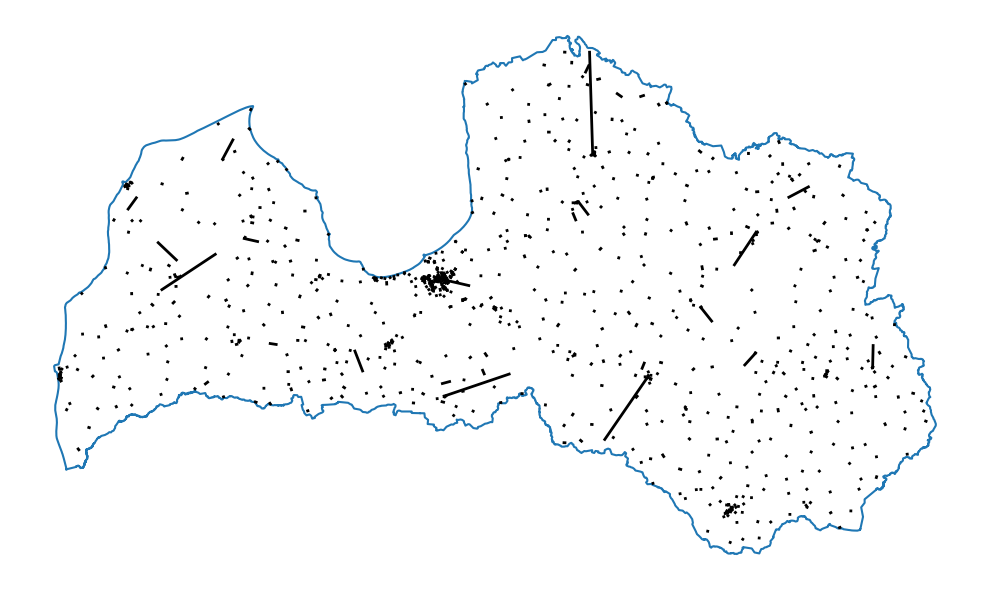

In [117]:
# Load coordinates
print('Loading coordinates', flush=True)
df_local_gmaps = pd.read_pickle(root+'gmaps-locations-local.pkl')
df_local_var = pd.read_pickle(root+'cvk-var-local.pkl')

# Construct data for scatter plot
print('Constructing data for scatter plot', flush=True)
x_old = np.array(df_local_gmaps['lat'])
y_old = np.array(df_local_gmaps['lng'])
x_new = []; y_new = []
for adrese in df_local_gmaps['Address']:
    var_row_index = np.where(df_local_var['adrese'] == adrese)[0][0]
    current_row = df_local_var.iloc[var_row_index]
    current_pair = LKSToLatLon(current_row['x-lks-92'], current_row['y-lks-92'])
    x_new.append(current_pair[0])
    y_new.append(current_pair[1])

# Initialize figure
fig = plt.figure(figsize=(10,6))
ax = plt.gca()

# Draw boundary
print('Drawing boundary', flush=True)
ax.plot(boundary_forplotting[0], boundary_forplotting[1])

# Draw old locs
print('Drawing old locations', flush=True)
# ax.scatter(y_old,x_old,alpha=.5,c='C0',edgecolors='none')

# Draw old locs
print('Drawing new locations', flush=True)
# ax.scatter(y_new,x_new,alpha=.5,c='C1',edgecolors='none')

# Draw lengths from/to
print('Drawing from old to new', flush=True)
for x1,y1,x2,y2 in zip(x_old,y_old,x_new,y_new):
    ax.plot([y1,y2],[x1,x2],c=(0,0,0),lw=2)
    
# Style
ax.axis('off')

# Save and show
print('Rendering',flush=True)
plt.tight_layout()
plt.savefig(export_dir+'gmaps-errors.png',dpi=300)
plt.show()